# Rolling Window Regression
**Gauge Units**: **feet**

**Goals**
- Columns will be 7 days of gauge data, 1 column either rainfall/discharge for that week

## To Do
- Look up uses for training and test data split
- Use SARIMA to forecast

### Resources
- [Designing ARIMA models using ACF/PACF plots](https://towardsdatascience.com/identifying-ar-and-ma-terms-using-acf-and-pacf-plots-in-time-series-forecasting-ccb9fd073db8)
- [SARIMA Modeling](https://github.com/marcopeix/time-series-analysis/blob/master/Advanced%20modelling/SARIMA.ipynb)
- [SARIMA Forecasting 1](https://www.wisdomgeek.com/development/machine-learning/sarima-forecast-seasonal-data-using-python/)
- [SARIMA Forecasting 2](https://medium.datadriveninvestor.com/time-series-prediction-using-sarimax-a6604f258c56)
- [Time Series Notebook](https://www.kaggle.com/code/andreshg/timeseries-analysis-a-complete-guide)

**Procedure**
- Data Cleanup
- Visual Stationarity check
- ADF Test
- SARIMA Modeling

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt # Visualization
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from datetime import date

from itertools import product

np.random.seed(0)
sns.set()

In [2]:
gauge = pd.read_csv("Data/Daily_Max_Vals.csv", index_col=0)
gauge.head()

date   stid  gauge  discharge  rainfall_inches  rainfall_ft
0  2007-10-01  RA101   2.40       23.9              0.0          0.0
1  2007-10-02  RA101   2.39       23.2              0.0          0.0
2  2007-10-03  RA101   2.39       23.2              0.0          0.0
3  2007-10-04  RA101   2.39       23.2              0.0          0.0
4  2007-10-05  RA101   2.42       25.2              0.0          0.0

In [3]:
gauge = gauge[['date', 'gauge']]
gauge.head()

date  gauge
0  2007-10-01   2.40
1  2007-10-02   2.39
2  2007-10-03   2.39
3  2007-10-04   2.39
4  2007-10-05   2.42

Since this is a TimeSeries problem, we have to parse 'date' column

In [4]:
gauge['date'] = pd.to_datetime(gauge['date'], infer_datetime_format=True)
gauge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5477 entries, 0 to 5476
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5477 non-null   datetime64[ns]
 1   gauge   5477 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 128.4 KB


In [5]:
# No null values!
gauge.isnull().sum()

date     0
gauge    0
dtype: int64

<AxesSubplot:xlabel='date', ylabel='gauge'>

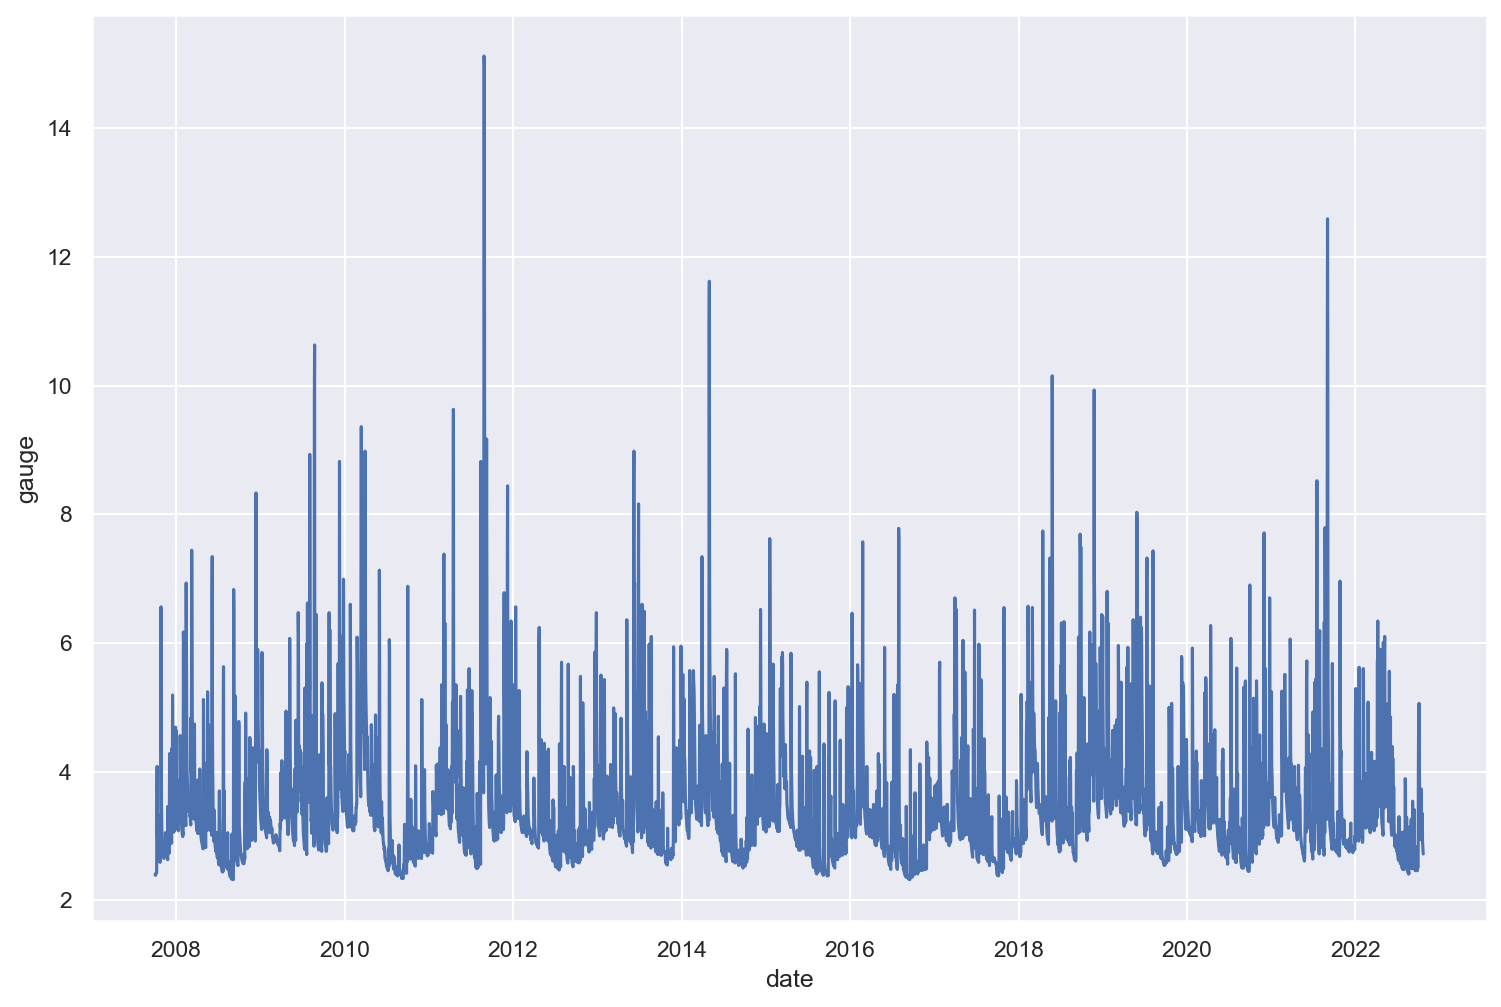

In [6]:
plt.figure(figsize=(12,8), dpi=150)
sns.lineplot(x=gauge['date'], y=gauge['gauge'])

### Data Pre-Processing

In [7]:
# Resample data to monthly based on max value
gauge = gauge.set_index('date')
gauge = pd.DataFrame(gauge['gauge'].resample('W-SUN').max()).reset_index()
gauge.head()

date  gauge
0 2007-10-07   2.43
1 2007-10-14   4.08
2 2007-10-21   3.33
3 2007-10-28   6.56
4 2007-11-04   3.49

## Stationarity

Some time-series models such as ARIMA assume that the underlying data is stationary. Stationarity describes that the time-series has

* constant mean and mean is not time-dependent
* constant variance and variance is not time-dependent
* constant covariance and covariance is not time-dependent

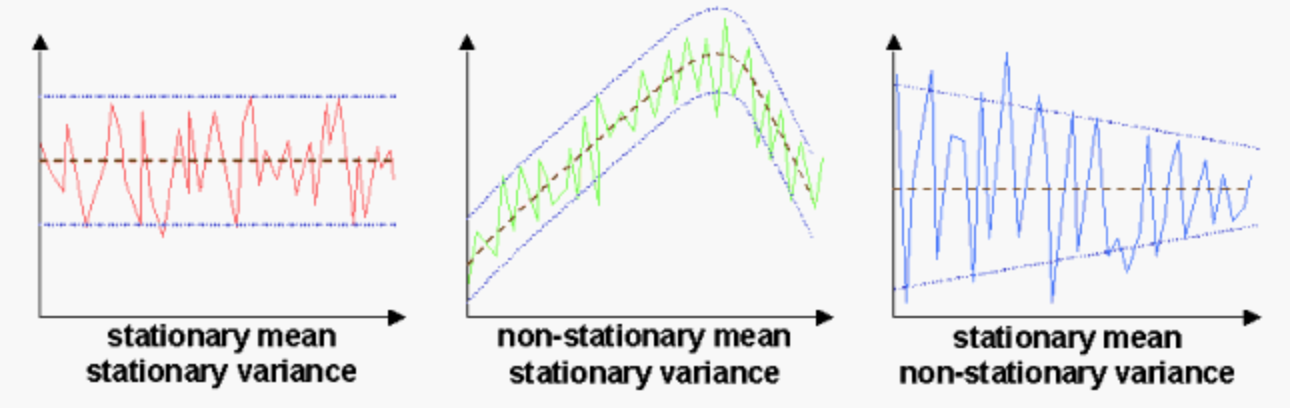

The check for stationarity can be done via three different approaches:

1. **visually**: plot time series and check for trends or seasonality
2. **basic statistics**: split time series and compare the mean and variance of each partition
3. **statistical test**: Augmented Dickey Fuller test

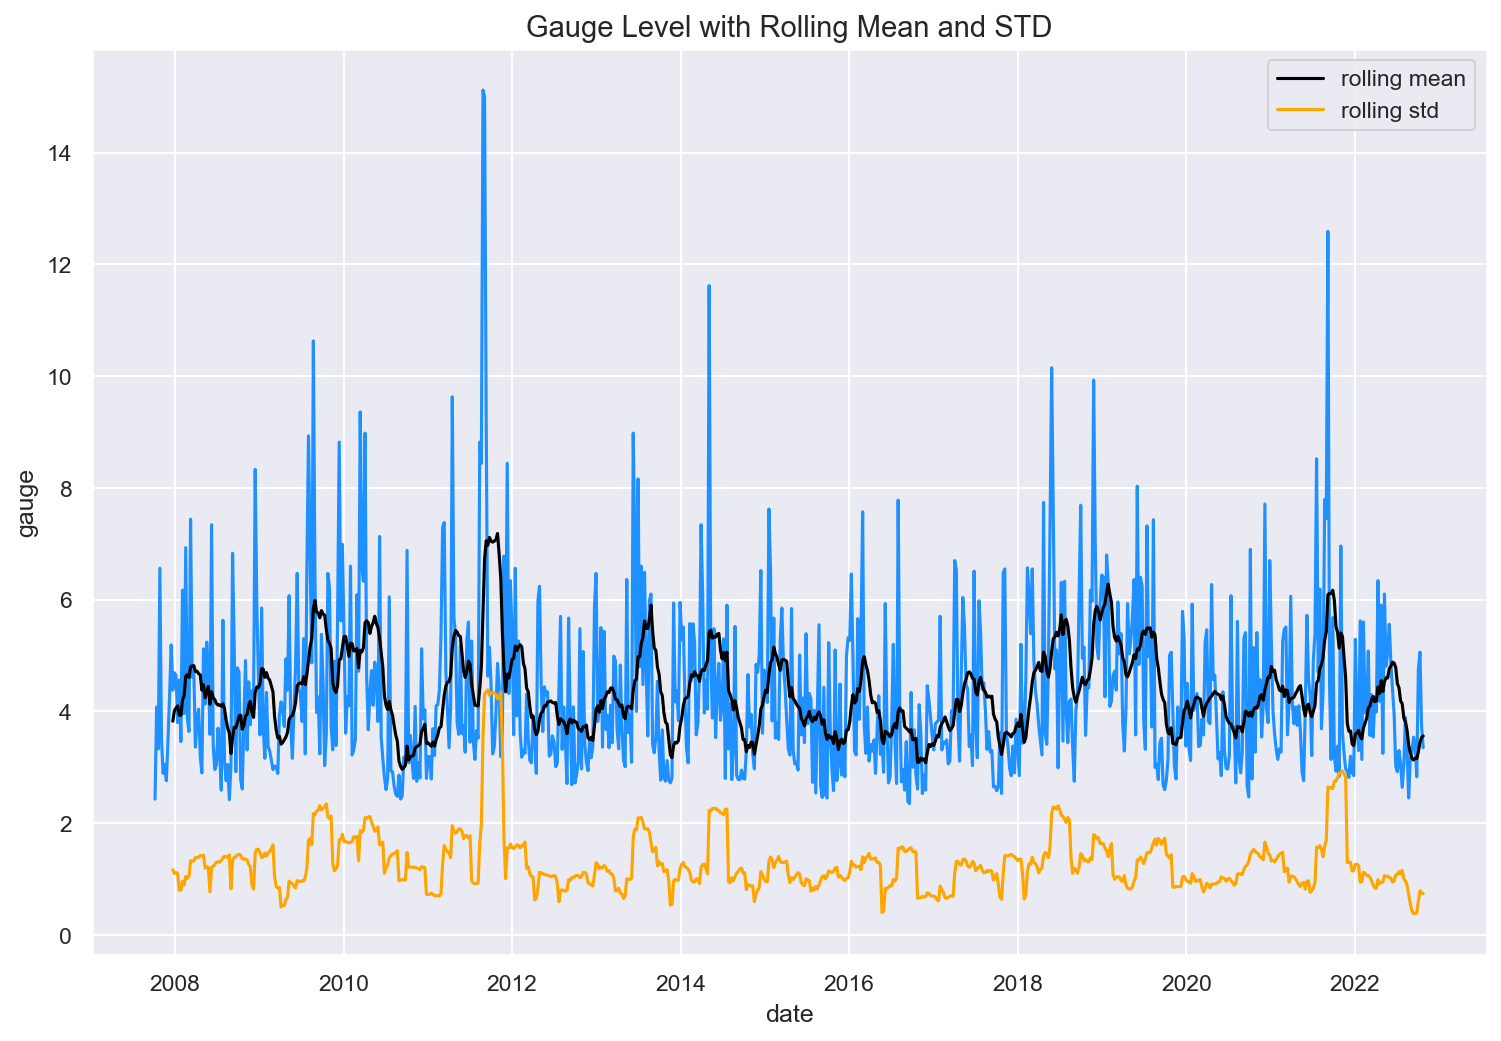

In [8]:
rolling_window = 12 # months in a year
plt.figure(figsize=(12,8), dpi=150)

sns.lineplot(x=gauge['date'], y=gauge['gauge'], color='dodgerblue')
sns.lineplot(x=gauge['date'], y=gauge['gauge'].rolling(rolling_window).mean(), color='black', label='rolling mean')
sns.lineplot(x=gauge['date'], y=gauge['gauge'].rolling(rolling_window).std(), color='orange', label='rolling std')
		 
plt.title('Gauge Level with Rolling Mean and STD', fontsize=14)
plt.show()

In this **visual check**, we can see that the **features don't have constant mean and std**, but they are close to it.

## Augmented Dickey-Fuller (ADF)

**Augmented Dickey-Fuller (ADF)** test is a unit root test. Unit roots (complex roots >= 1) are a cause for non-stationarity.

- Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

- Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

**If the null hypothesis can be rejected, we can conclude that the time series is stationary.**

There are two ways to reject the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

* <font color='red'>**p-value > significance level (default: 0.05)**</font>: Fail to reject the null hypothesis (H0), the data has a unit root and is <font color='red'>non-stationary</font>.
* <font color='green'>**p-value <= significance level (default: 0.05)**</font>: Reject the null hypothesis (H0), the data does not have a unit root and is <font color='green'>stationary</font>.
    
On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.
* <font color='red'>**ADF statistic > critical value**</font>: Fail to reject the null hypothesis (H0), the data has a unit root and is <font color='red'>non-stationary</font>.
* <font color='green'>**ADF statistic < critical value**</font>: Reject the null hypothesis (H0), the data does not have a unit root and is <font color='green'>stationary</font>.

In [9]:
result = adfuller(gauge['gauge'].values)
result

(-11.769549257713383,
 1.0982610999781752e-21,
 2,
 783,
 {'1%': -3.4387291412780177,
  '5%': -2.8652383048736056,
  '10%': -2.568739332674375},
 2729.569857225759)

Now, we are going to check for each variable:
* The p-value is less than 0.05
* Check the range of the ADF statistic compared with critical_values 

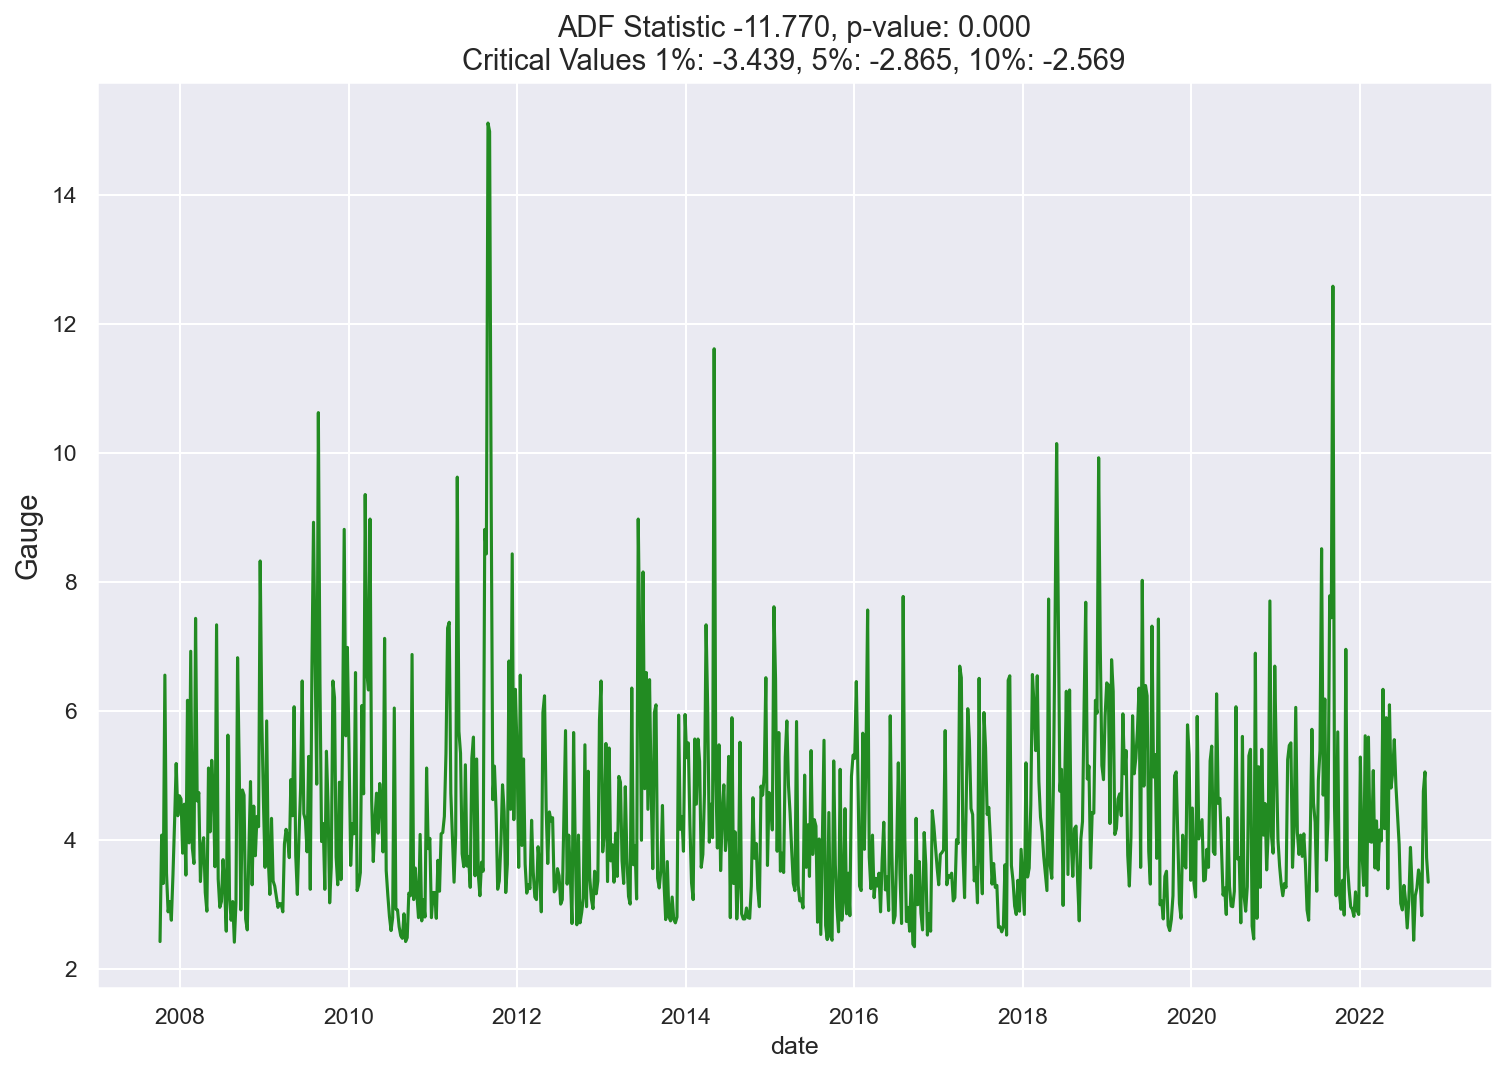

In [10]:
# Thanks to https://www.kaggle.com/iamleonie for this function!
plt.figure(figsize=(12,8), dpi=150)

def visualize_adfuller_results(series, title):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=gauge['date'], y=series, color=linecolor)
    plt.title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    plt.ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(gauge['gauge'], 'Gauge')
plt.show()

### The low p-value means we reject H0 and our data is stationary!
If our data were not stationary, it would need to be transformed using log, square root, or differencing.

However, it looks like our stationarity checks went well, so we can skip this transformation step!

## TimeSeries Decomposition

Time series decomposition breaks a series into components: level, trend, seasonality, and noise.

These components are defined as follows:

* **Level**: The average value in the series.
* **Trend**: The increasing or decreasing value in the series.
* **Seasonality**: The repeating short-term cycle in the series.
* **Noise**: The random variation in the series.

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

All series have a level and noise. The trend and seasonality components are optional.

It is helpful to think of the components as combining either additively or multiplicatively:
* **Additive**: $y(t) = Level + Trend + Seasonality + Noise$
* **Multiplicative**: $y(t) = Level * Trend * Seasonality * Noise$

In this case we are going to use seasonal_decompose() from the [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) library.

In [11]:
# Try different week-on-week periods to see where the seasonality is
periods = [1, 2, 4, 12, 24, 52, 104]

In [12]:
def plot_decomp(per=int):
	decomp = seasonal_decompose(gauge['gauge'], period=per, model='additive', extrapolate_trend='freq')
	gauge[f"gauge_trend"] = decomp.trend
	gauge[f"gauge_seasonal"] = decomp.seasonal
	decomp.plot()
	# Get current figure and adjust size; regular adjustment not working
	plt.gcf().set_size_inches(12, 12)
	print(f'Gauge, Period: {per} Months')
	plt.show()

Gauge, Period: 1 Months


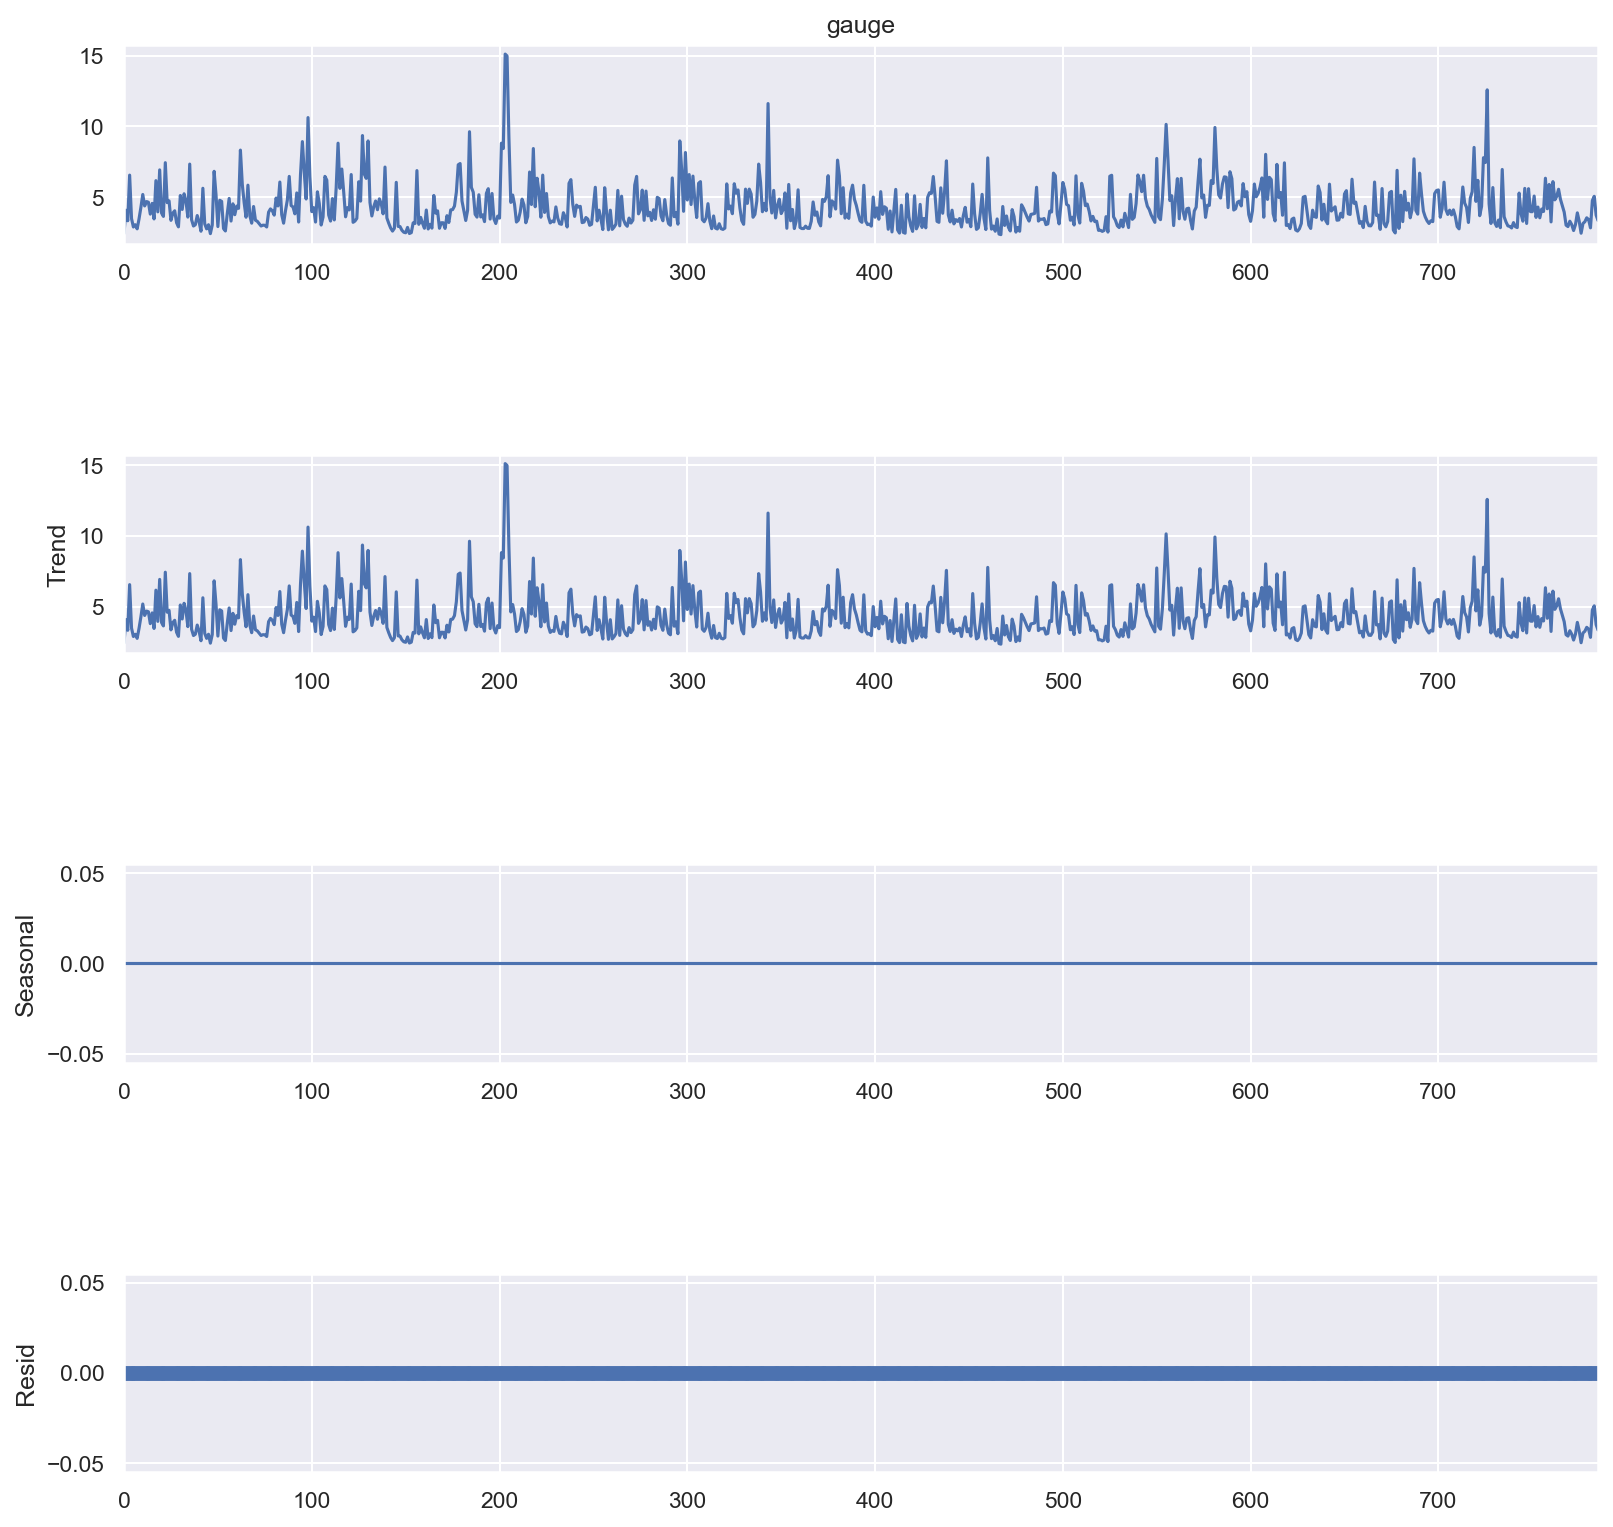

Gauge, Period: 2 Months


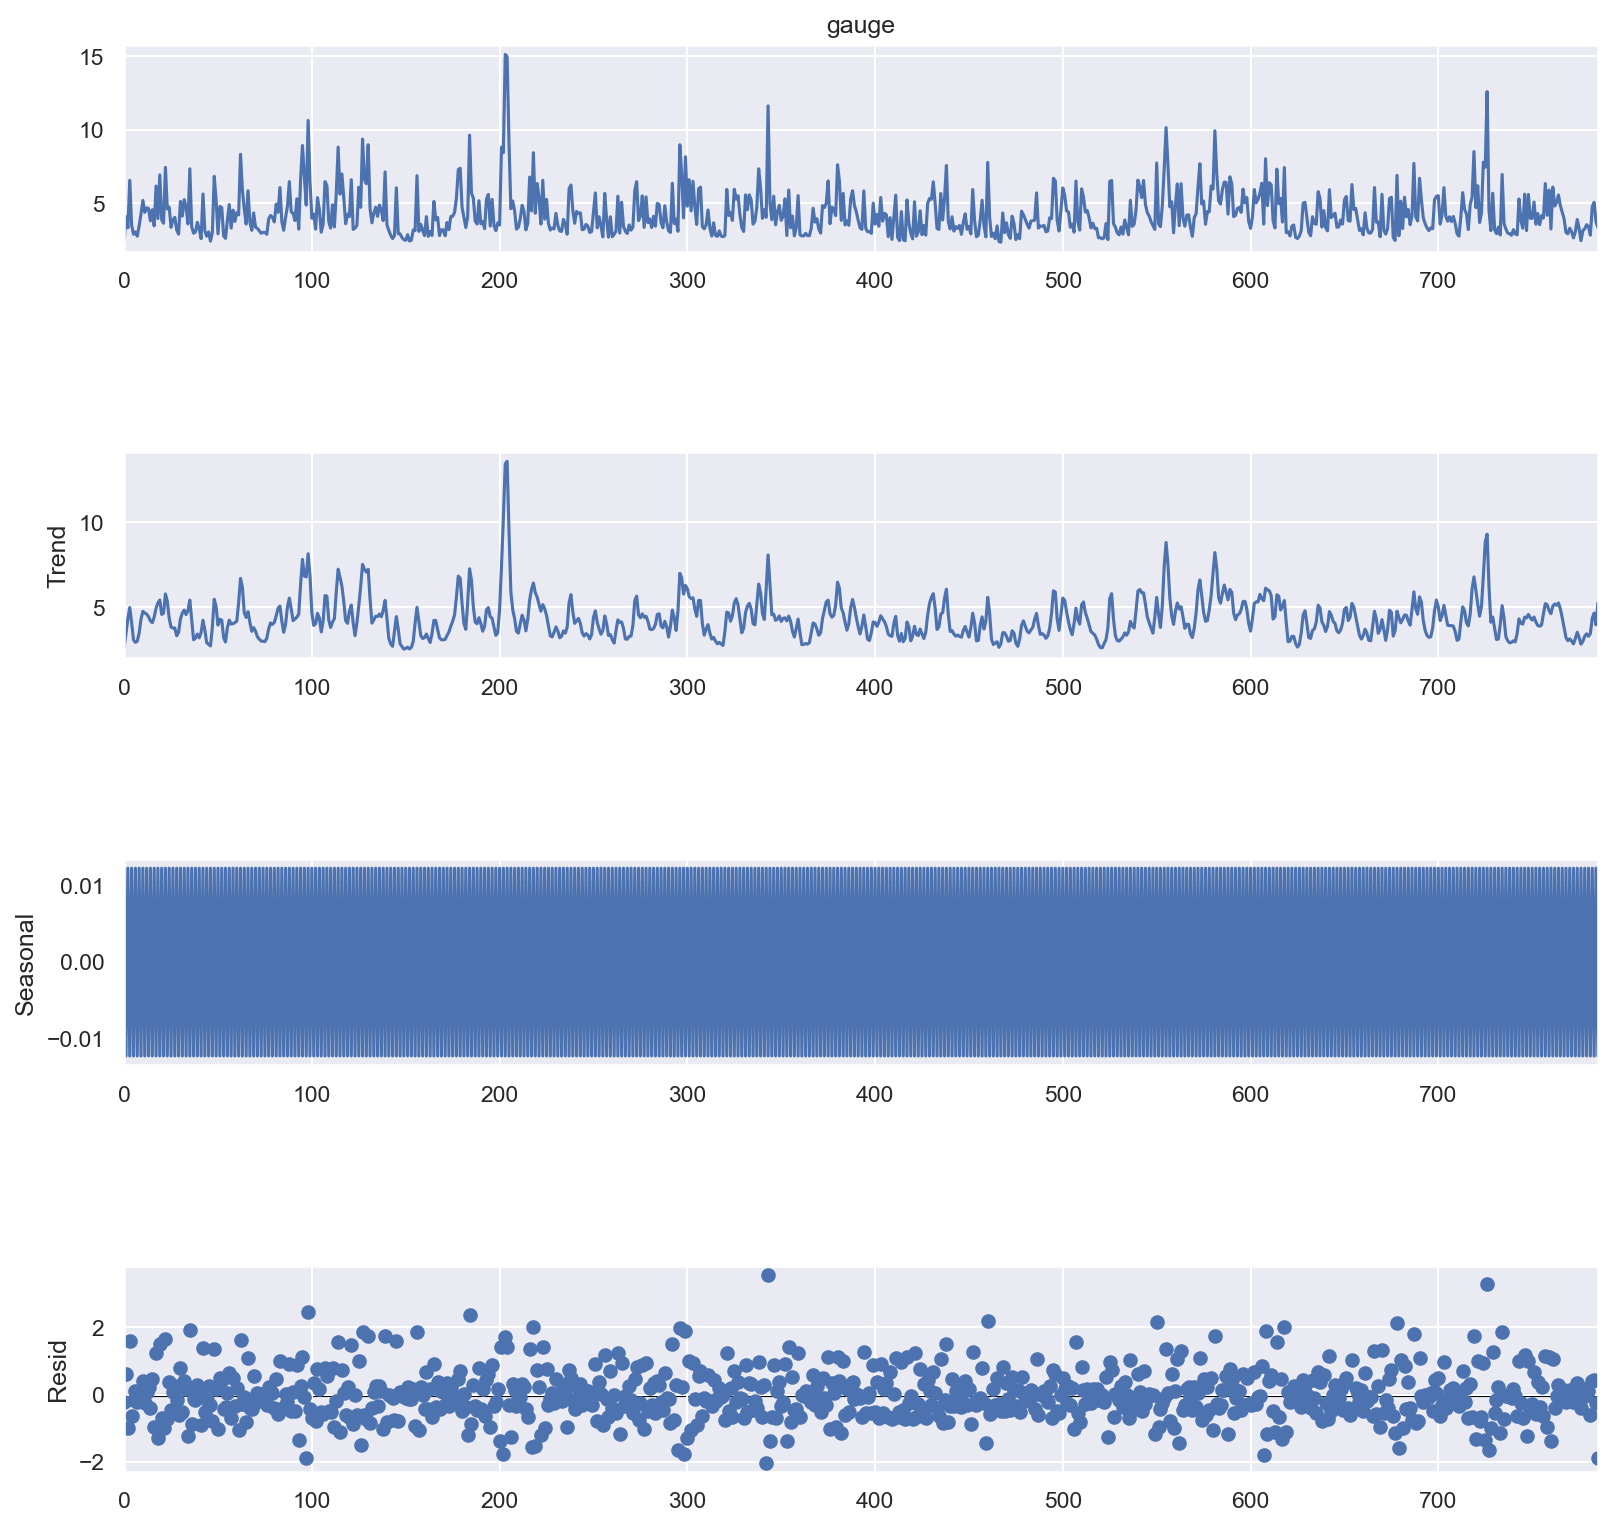

Gauge, Period: 4 Months


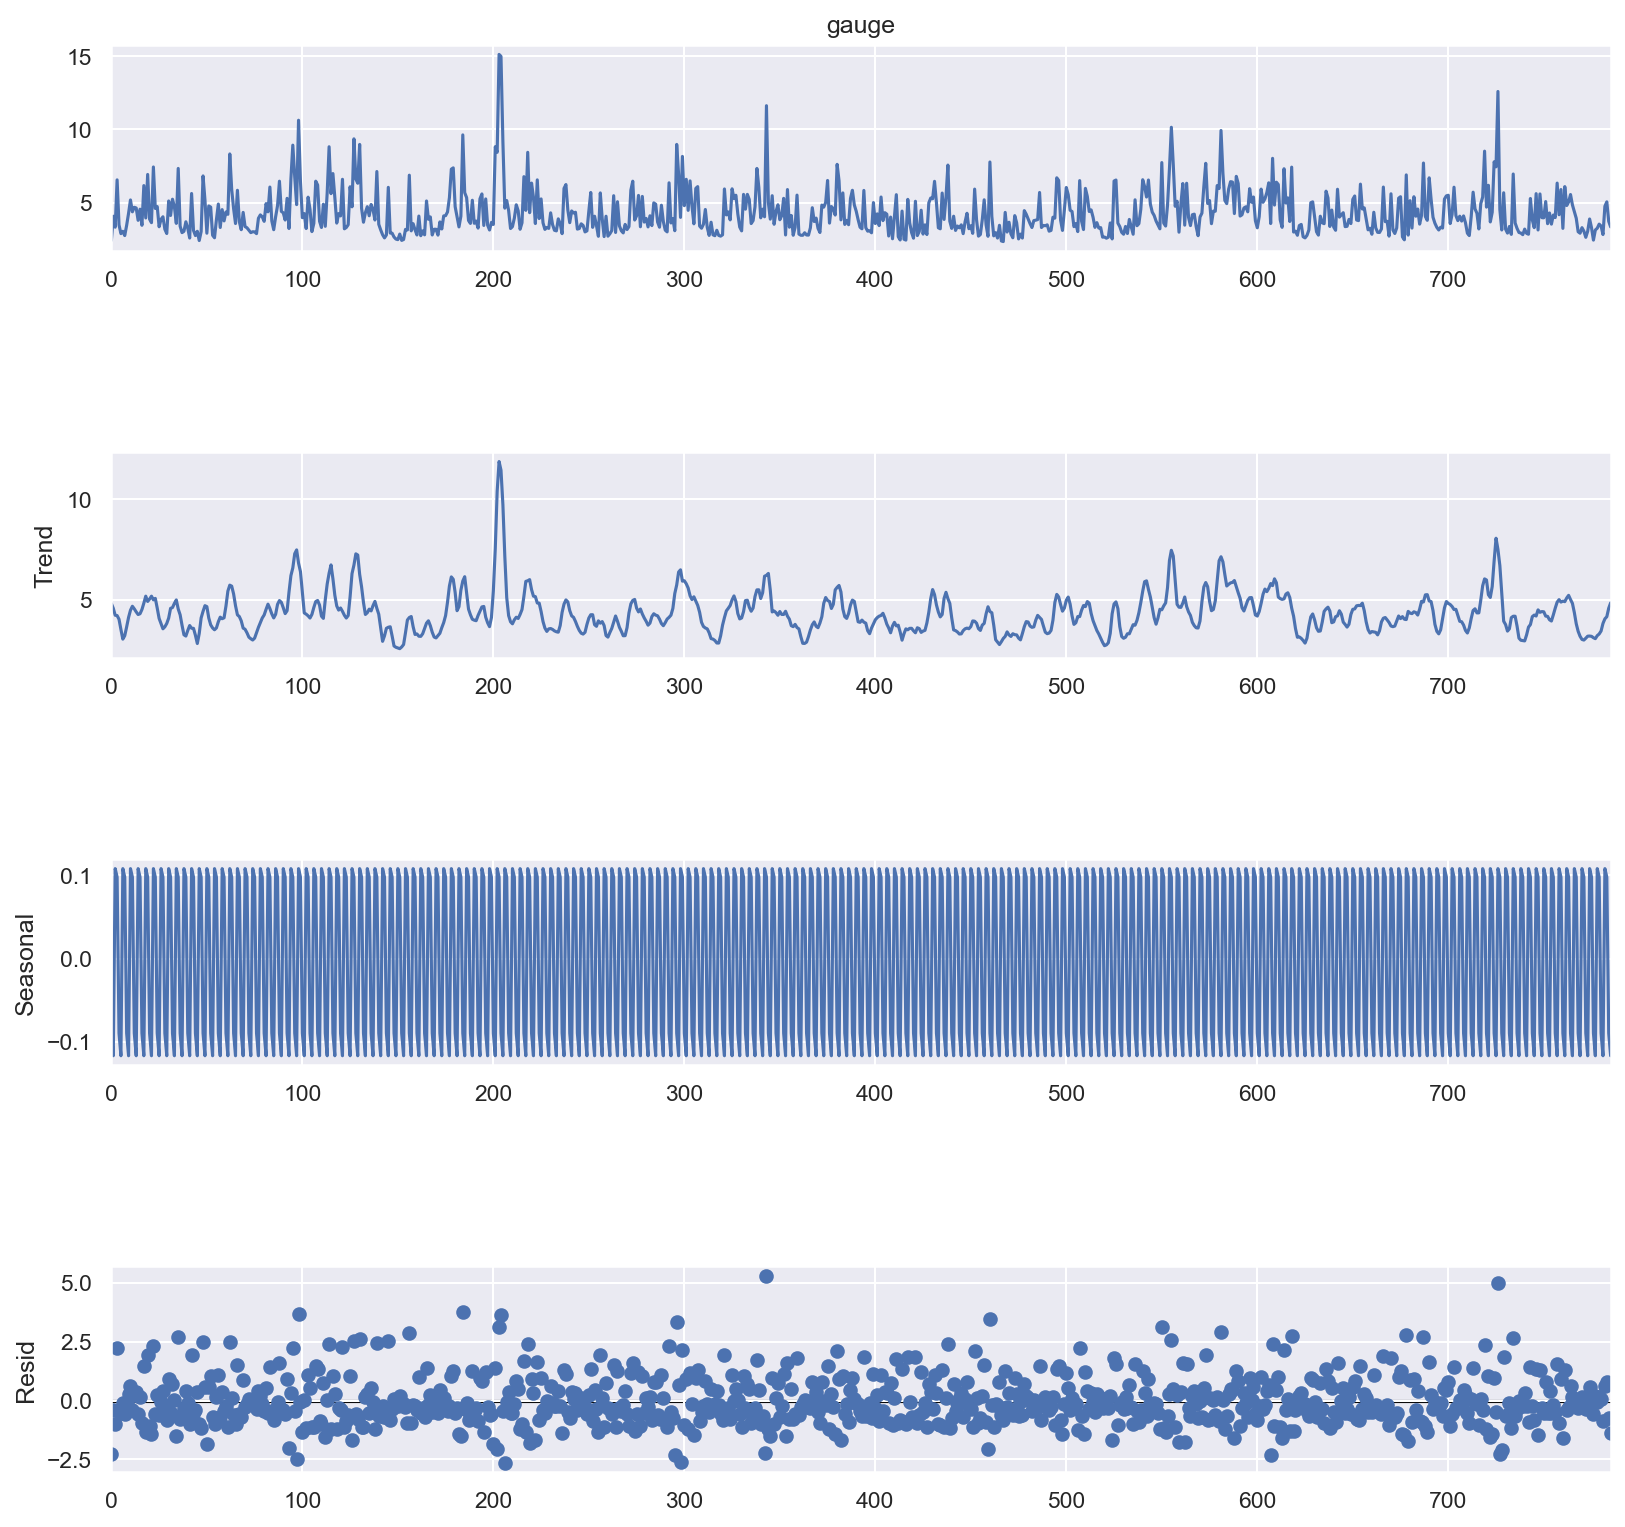

Gauge, Period: 12 Months


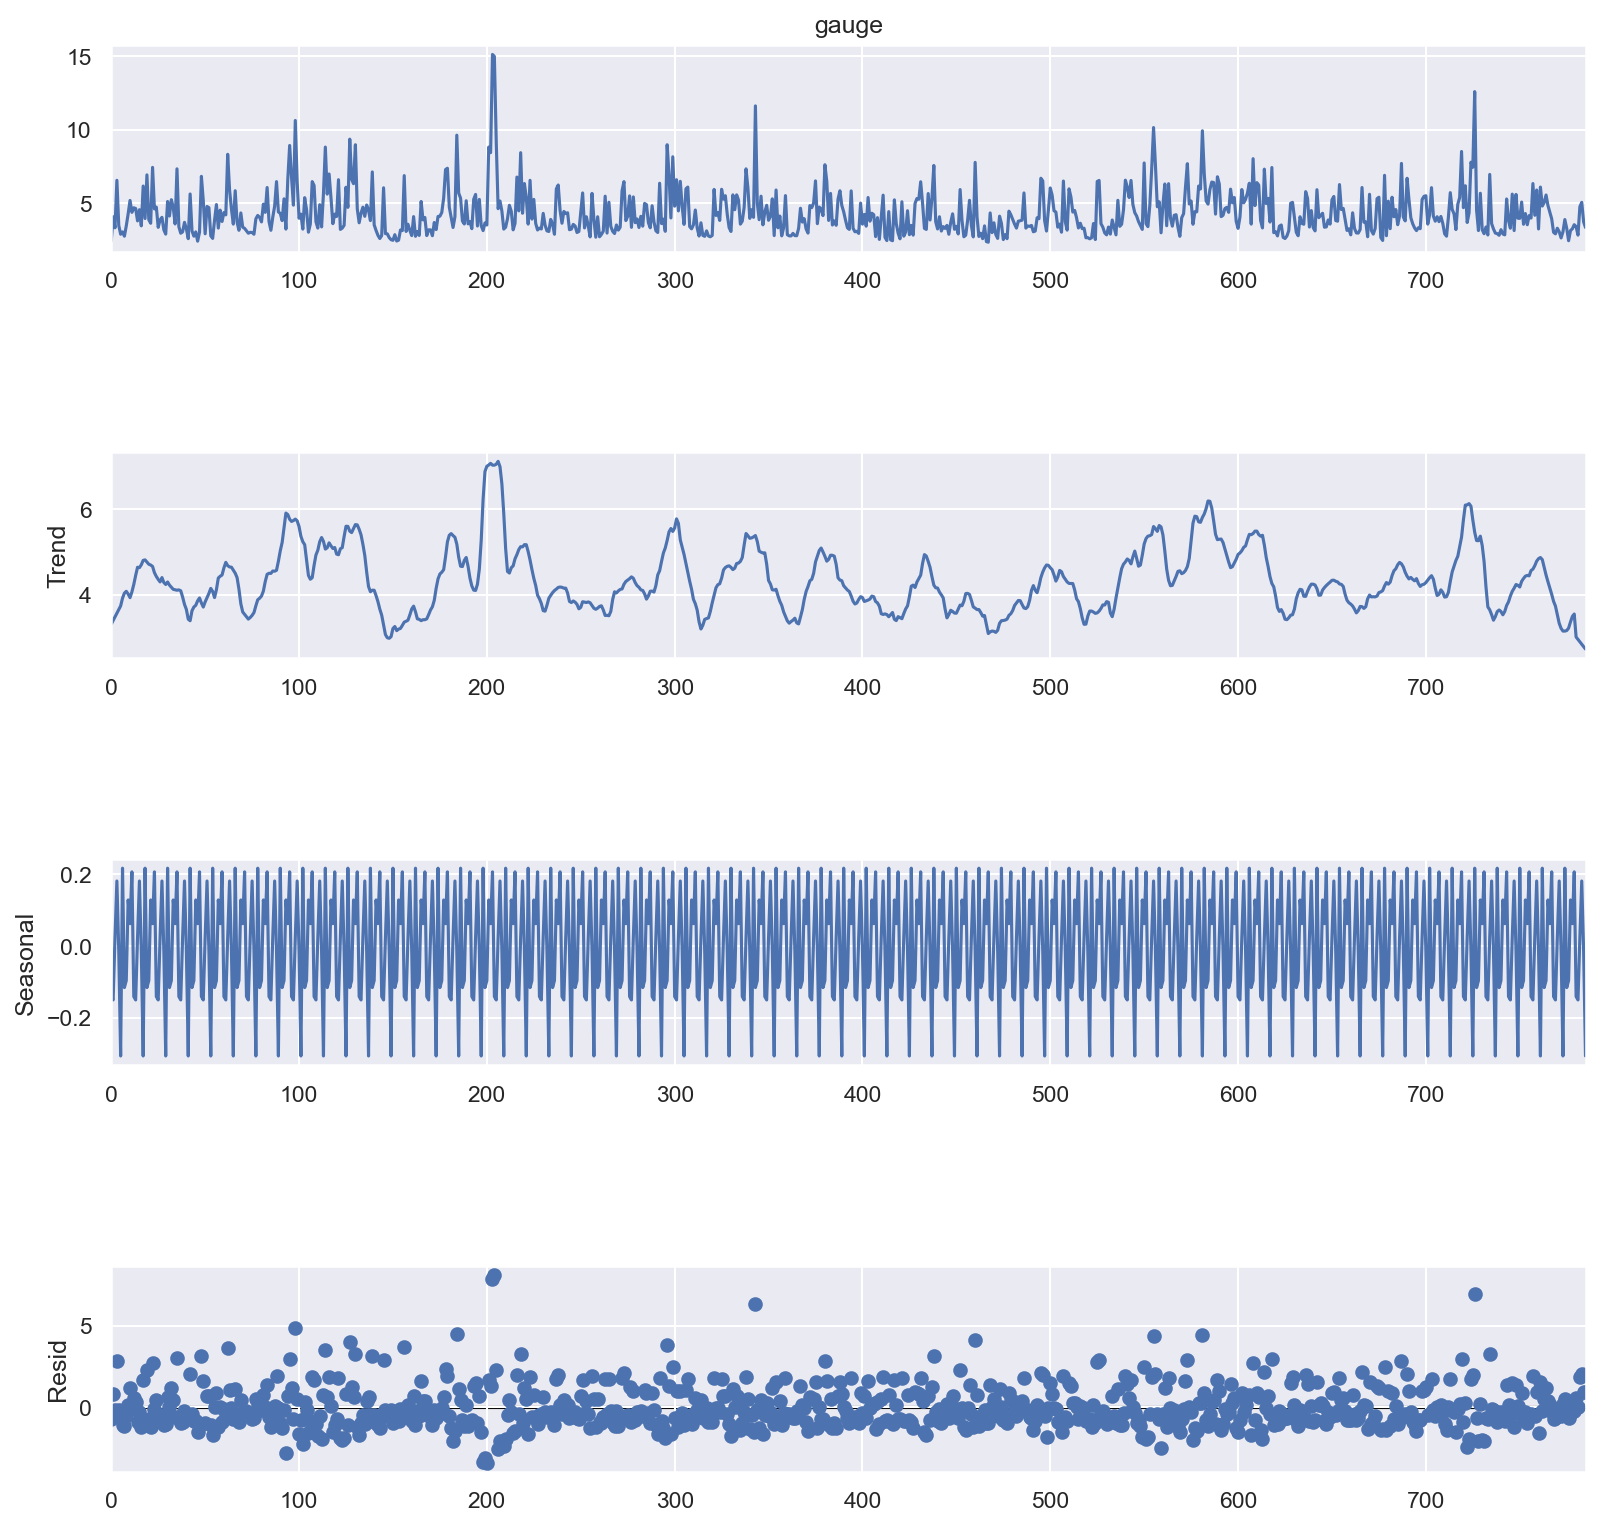

Gauge, Period: 24 Months


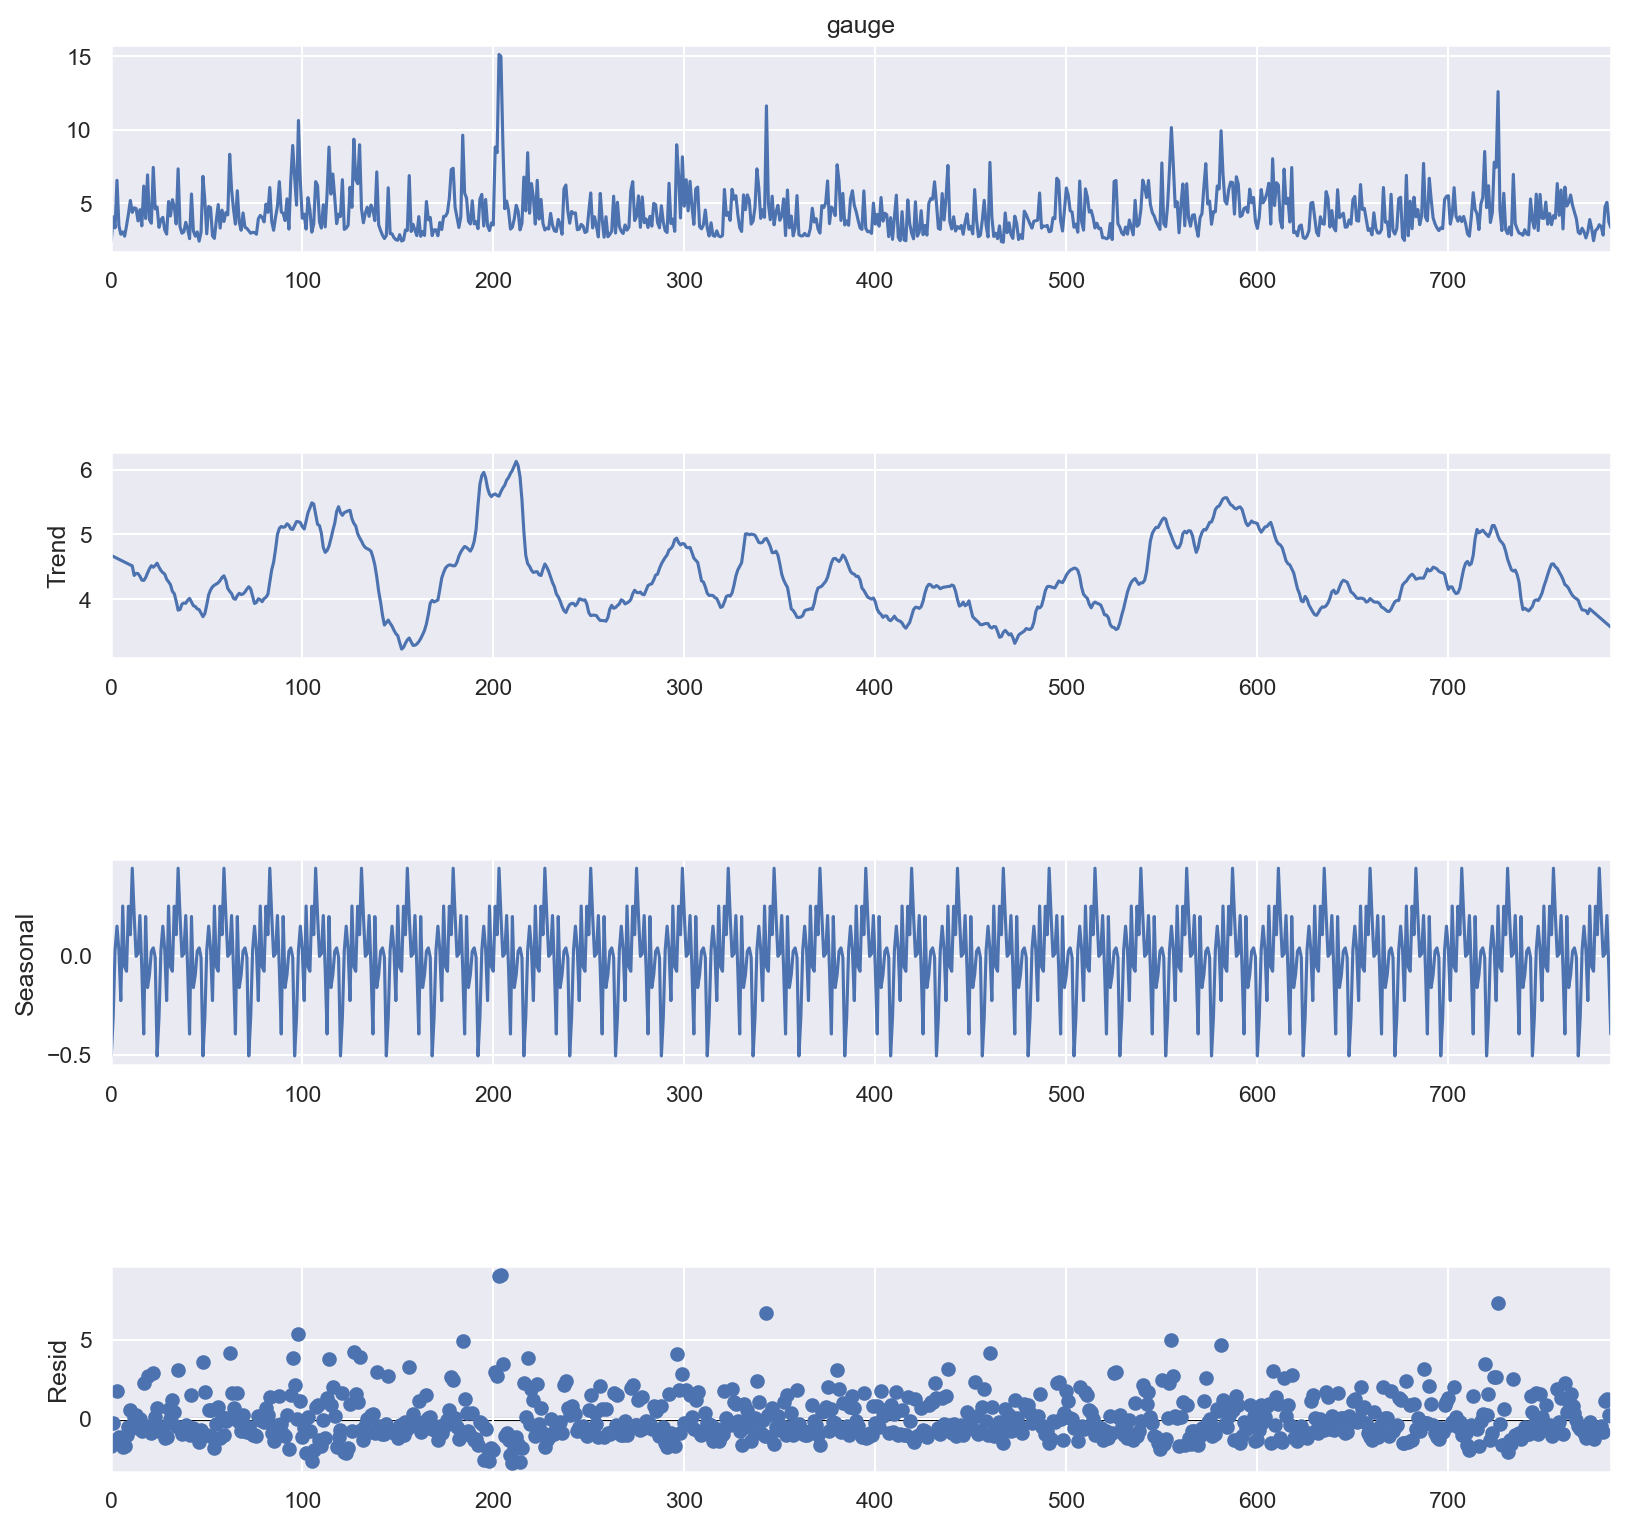

Gauge, Period: 52 Months


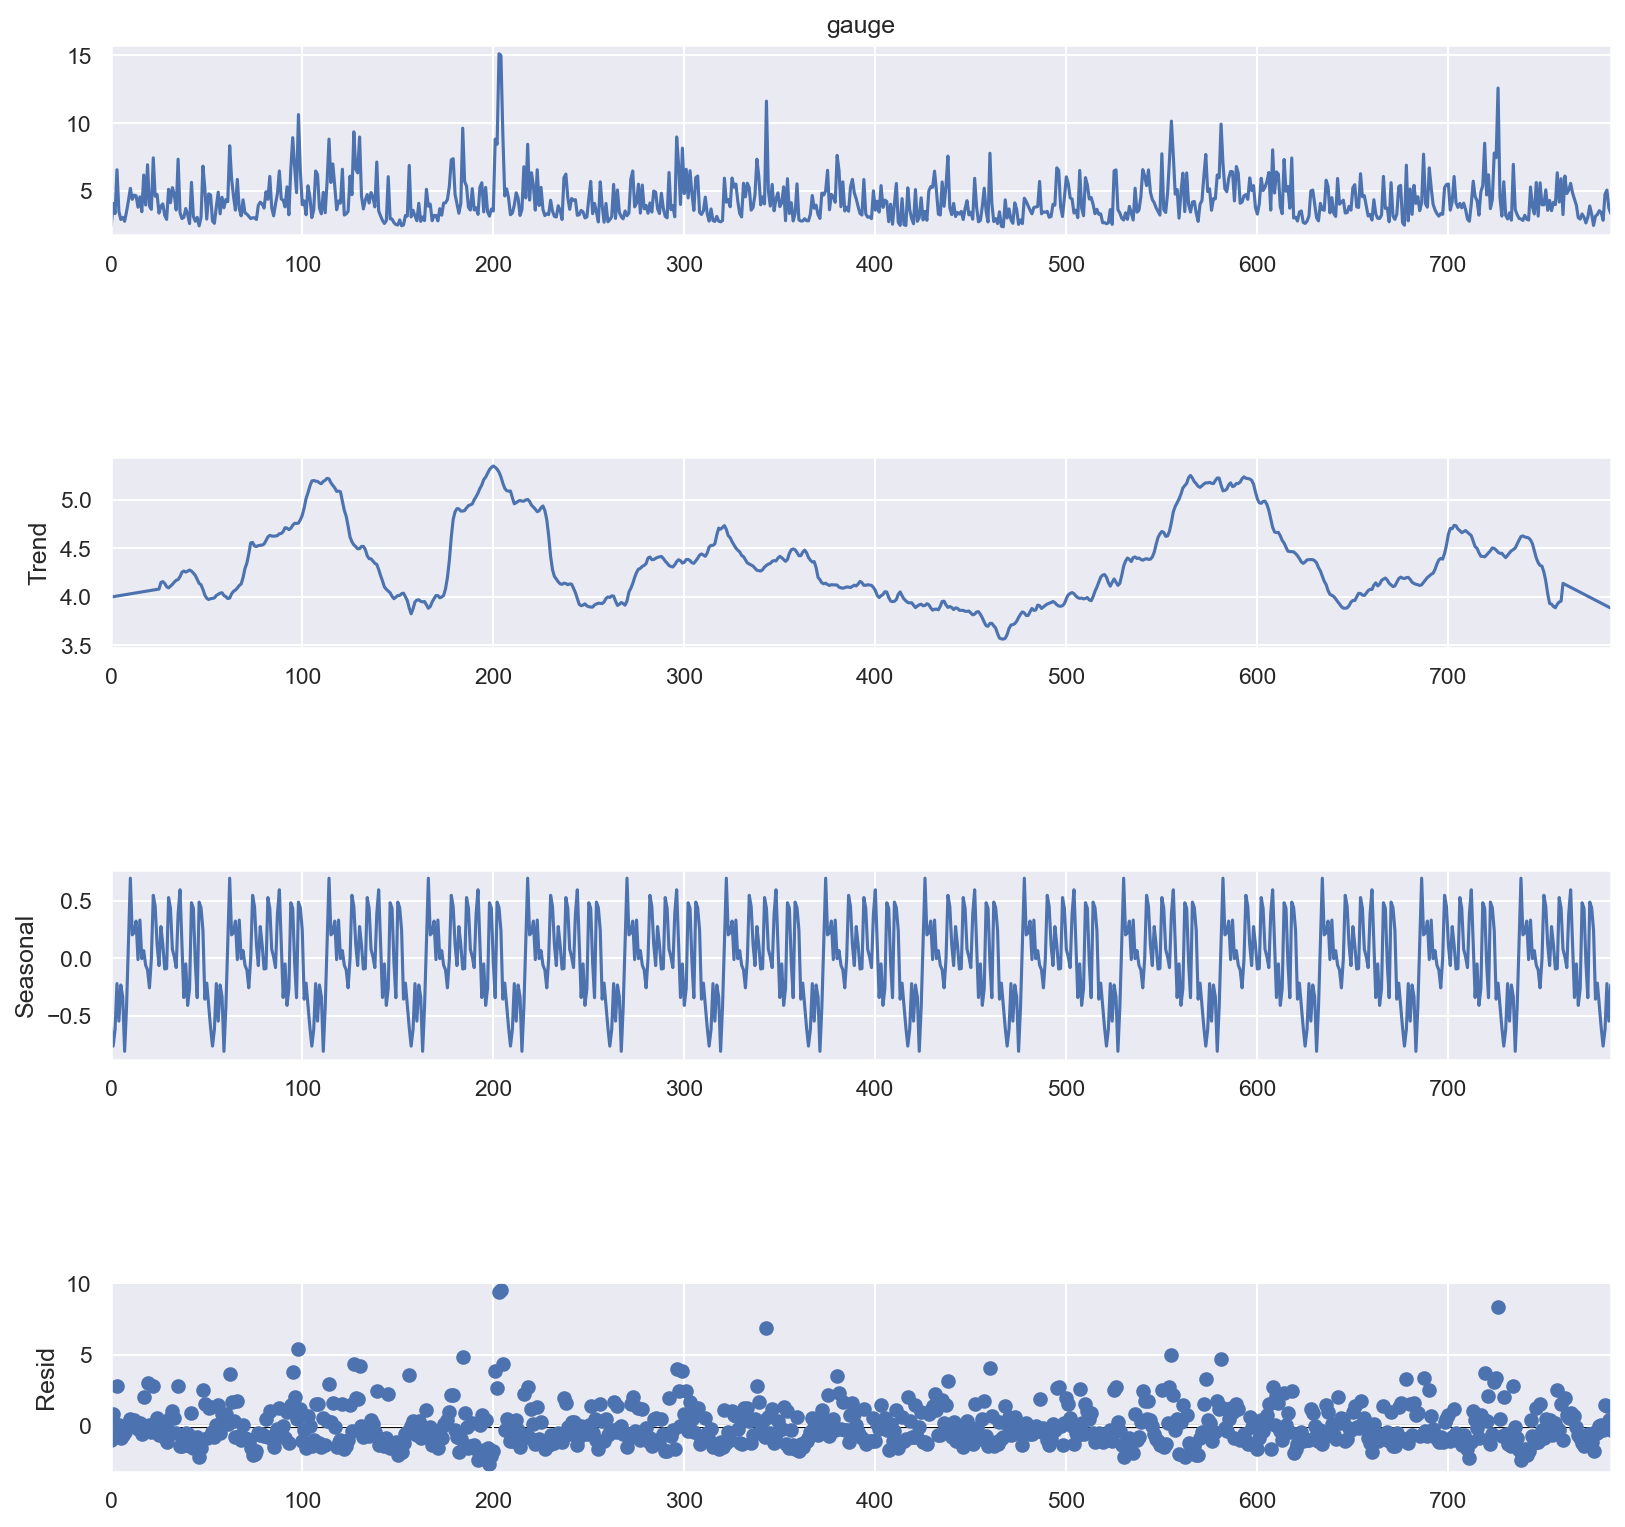

Gauge, Period: 104 Months


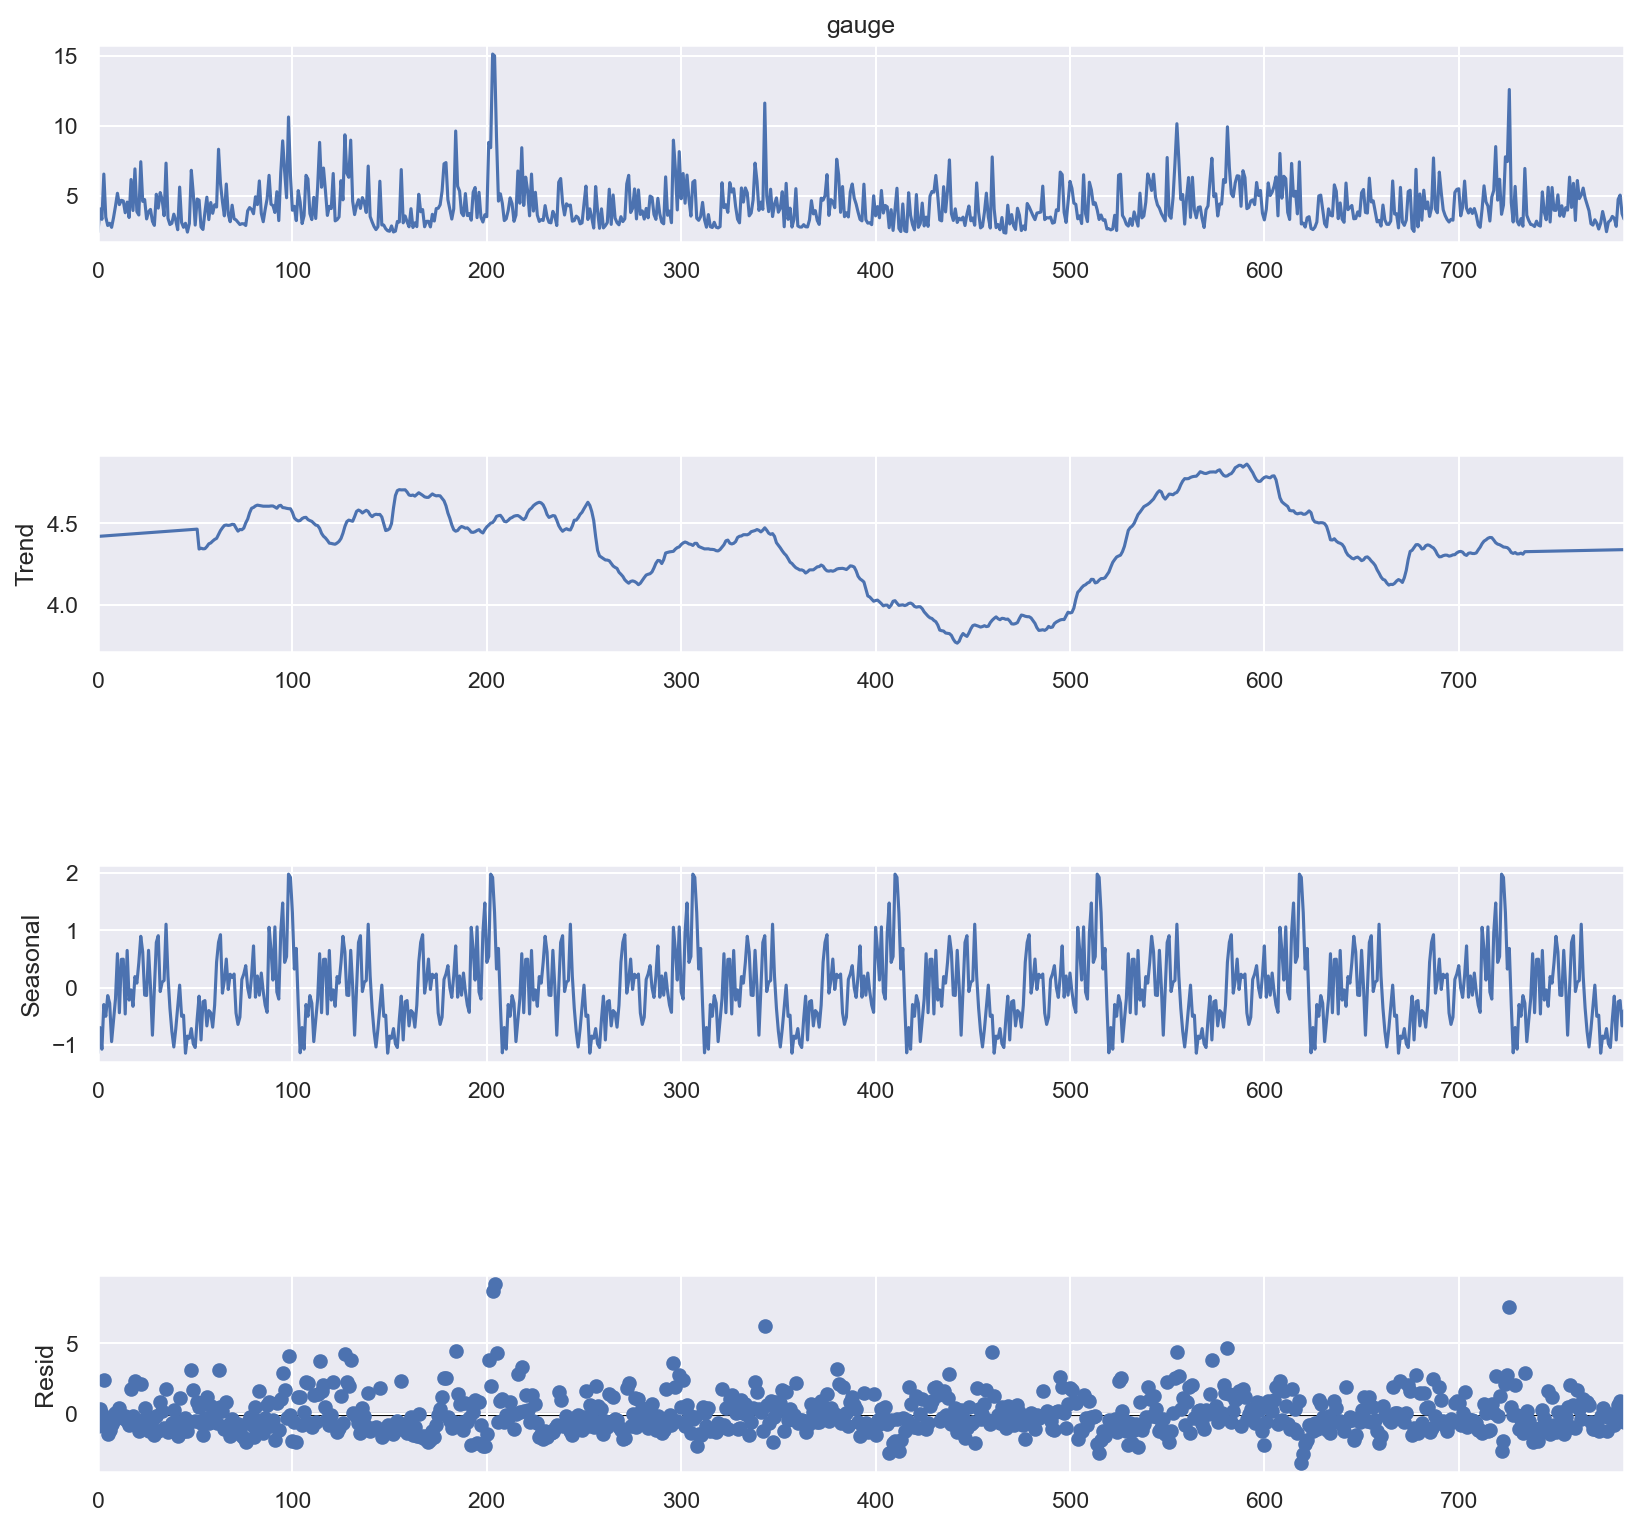

In [13]:
for period in periods:
	plot_decomp(period)

## Lag

We want to calculate each variable with a `shift()` (lag) to compare the correlation with the other variables.

You can see [documentation of shift function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) for more information.

In [14]:
weeks_in_month = 4

gauge[f'gauge_seasonal_shift_b_2m'] = gauge['gauge_seasonal'].shift(-2 * 4)
gauge[f'gauge_seasonal_shift_b_1m'] = gauge['gauge_seasonal'].shift(-1 * 4)
gauge[f'gauge_seasonal_shift_1m'] = gauge['gauge_seasonal'].shift(1 * weeks_in_month)
gauge[f'gauge_seasonal_shift_2m'] = gauge['gauge_seasonal'].shift(2 * weeks_in_month)
gauge[f'gauge_seasonal_shift_3m'] = gauge['gauge_seasonal'].shift(3 * weeks_in_month)

In [15]:
gauge.head()

date  gauge  gauge_trend  gauge_seasonal  gauge_seasonal_shift_b_2m  \
0 2007-10-07   2.43     4.418631       -1.135242                  -0.560325   
1 2007-10-14   4.08     4.419502       -0.694605                  -0.193932   
2 2007-10-21   3.33     4.420373       -1.072286                   0.590099   
3 2007-10-28   6.56     4.421244       -0.294420                  -0.437360   
4 2007-11-04   3.49     4.422115       -0.499553                   0.491737   

   gauge_seasonal_shift_b_1m  gauge_seasonal_shift_1m  \
0                  -0.499553                      NaN   
1                  -0.138977                      NaN   
2                  -0.271512                      NaN   
3                  -0.939873                      NaN   
4                  -0.560325                -1.135242   

   gauge_seasonal_shift_2m  gauge_seasonal_shift_3m  
0                      NaN                      NaN  
1                      NaN                      NaN  
2                      NaN                      NaN  
3                      NaN                      NaN  
4                      NaN                      NaN

## Exploratory Data Analysis

Now, we'll plot the seasonality components and try to extract some knowledge.

In [16]:
gauge_3yr = gauge[gauge['date'] >= pd.Timestamp(2019,1,1)]
gauge_2020 = gauge[gauge['date'] >= pd.Timestamp(2020,1,1)]
gauge_2020 = gauge_2020[gauge_2020['date'] < pd.Timestamp(2021,1,1)]
gauge_2021 = gauge[gauge['date'] >= pd.Timestamp(2021,1,1)]
gauge_2021 = gauge_2021[gauge_2021['date'] < pd.Timestamp(2022,1,1)]

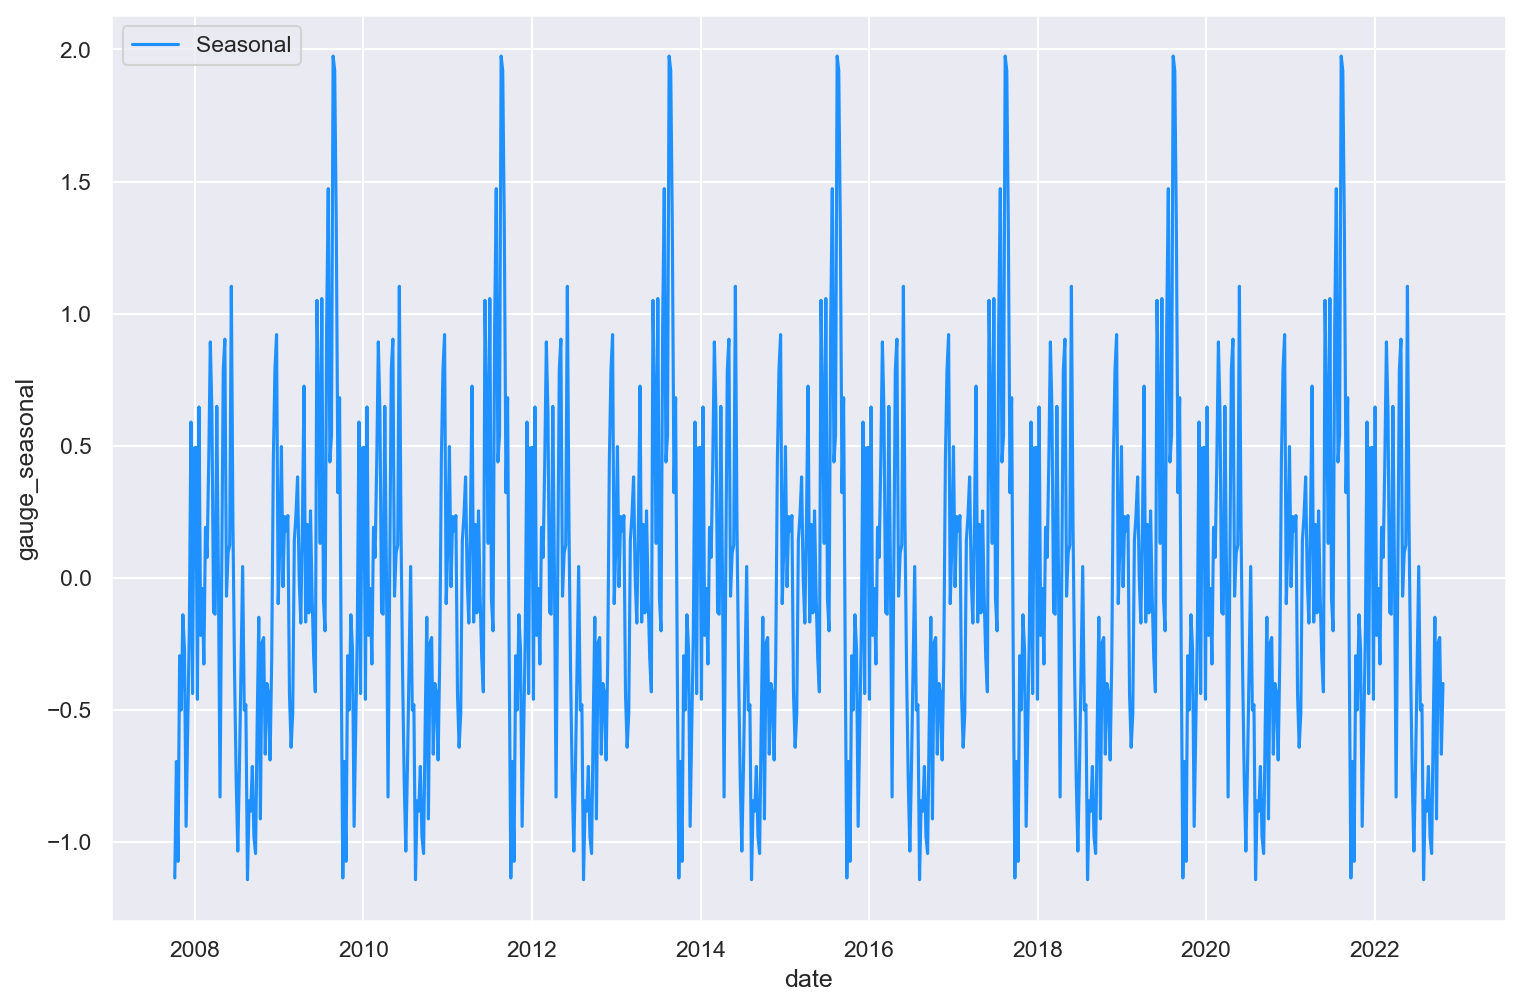

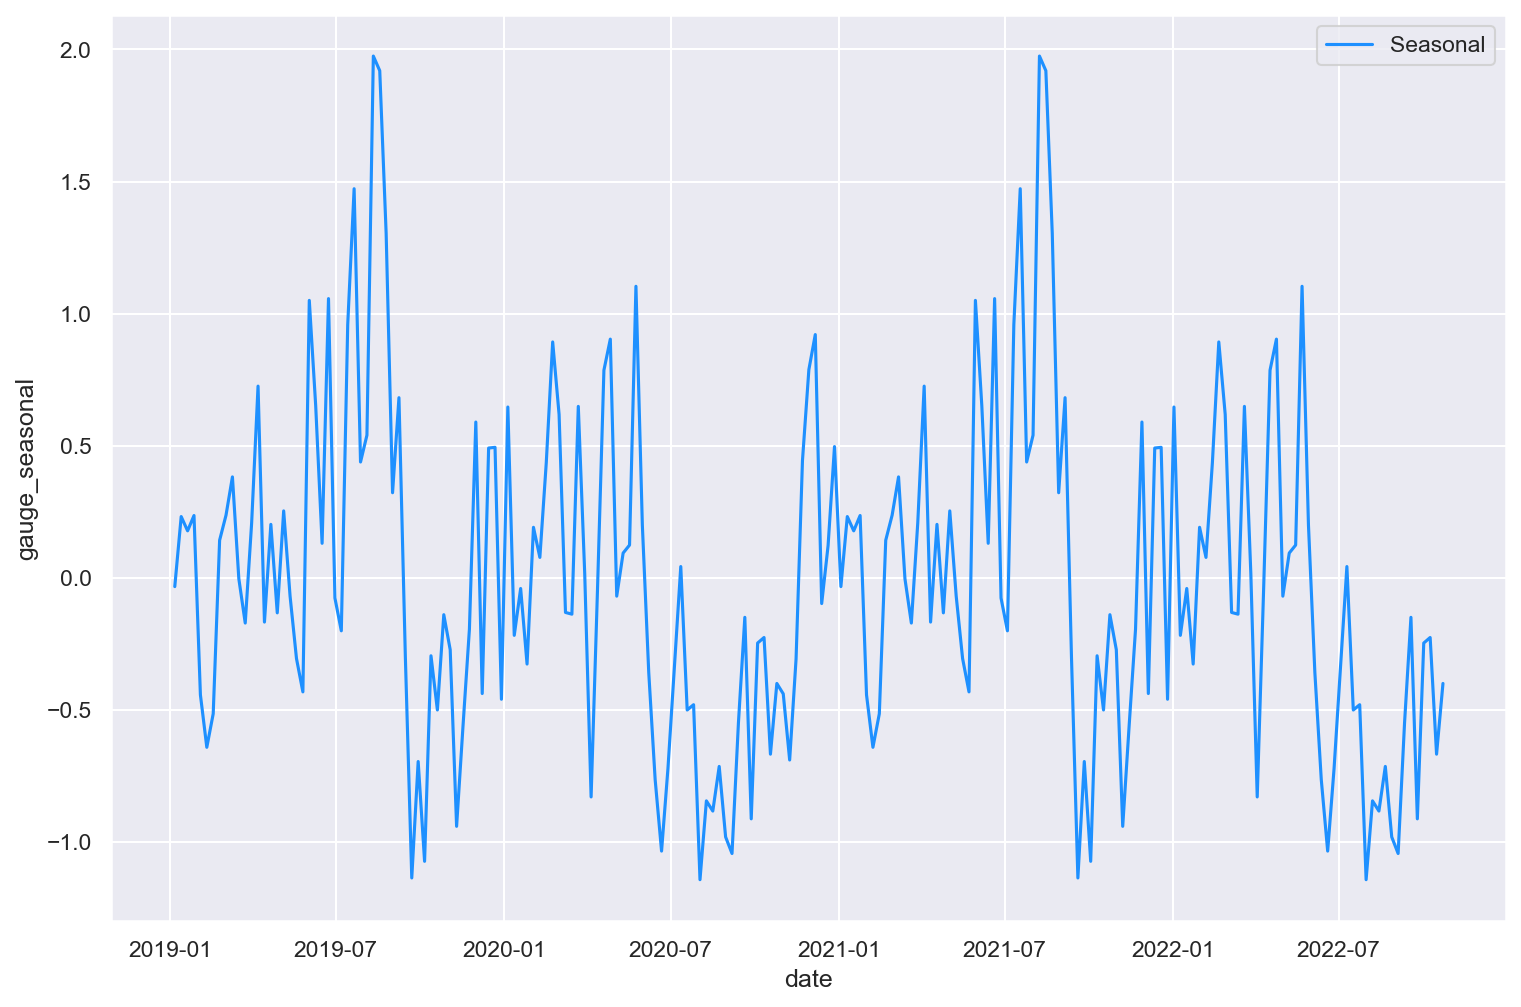

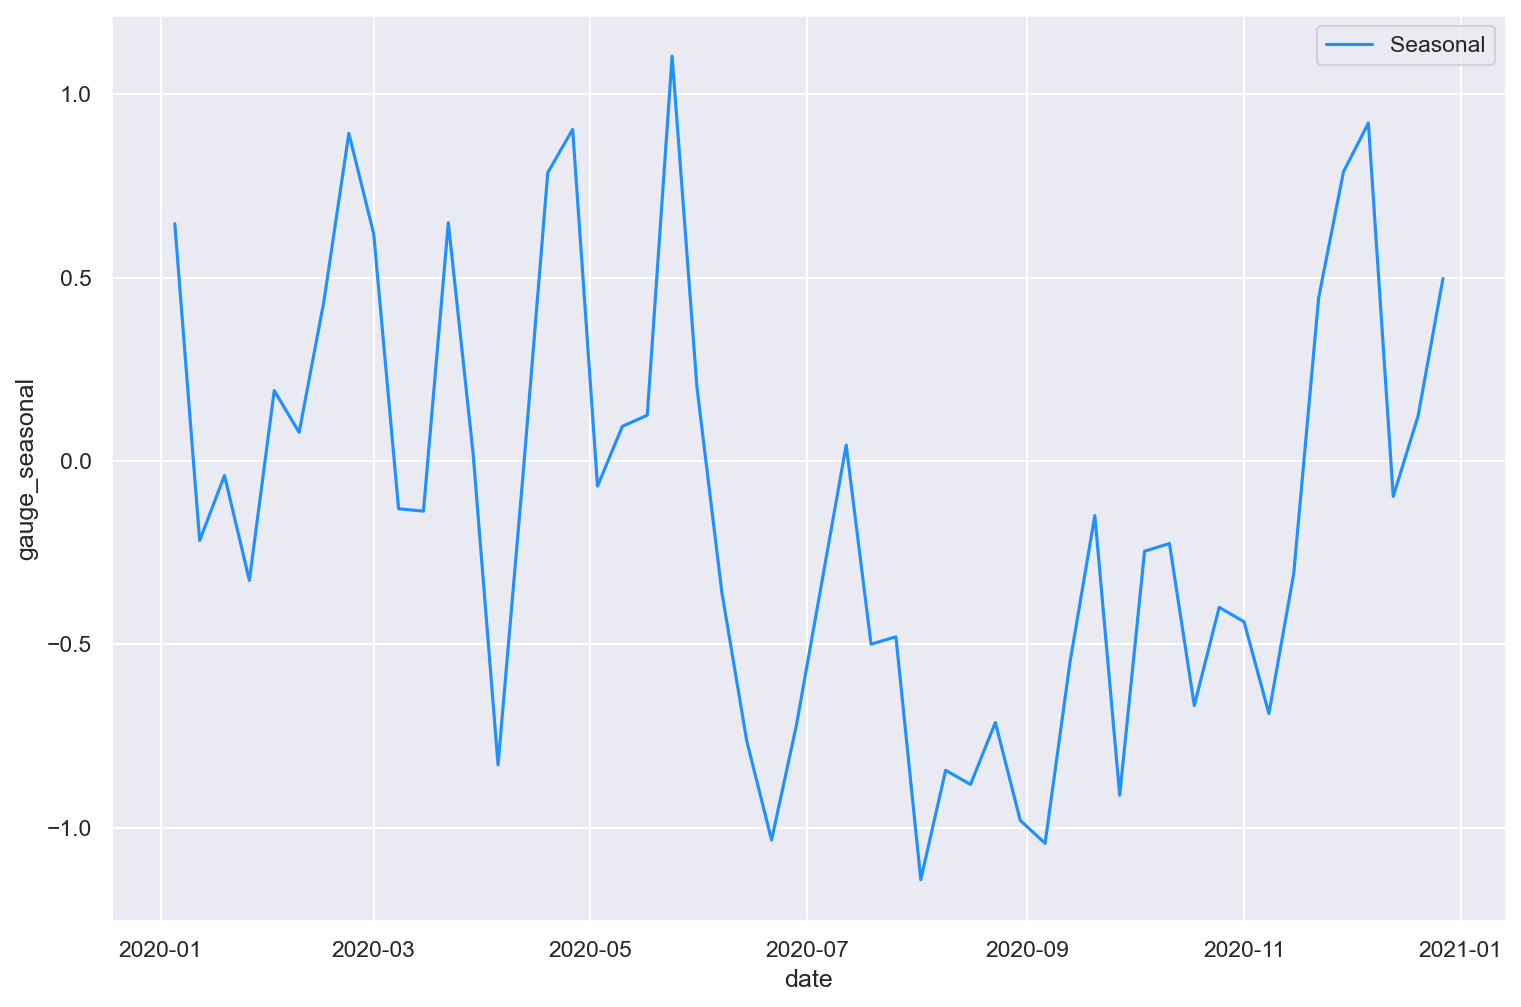

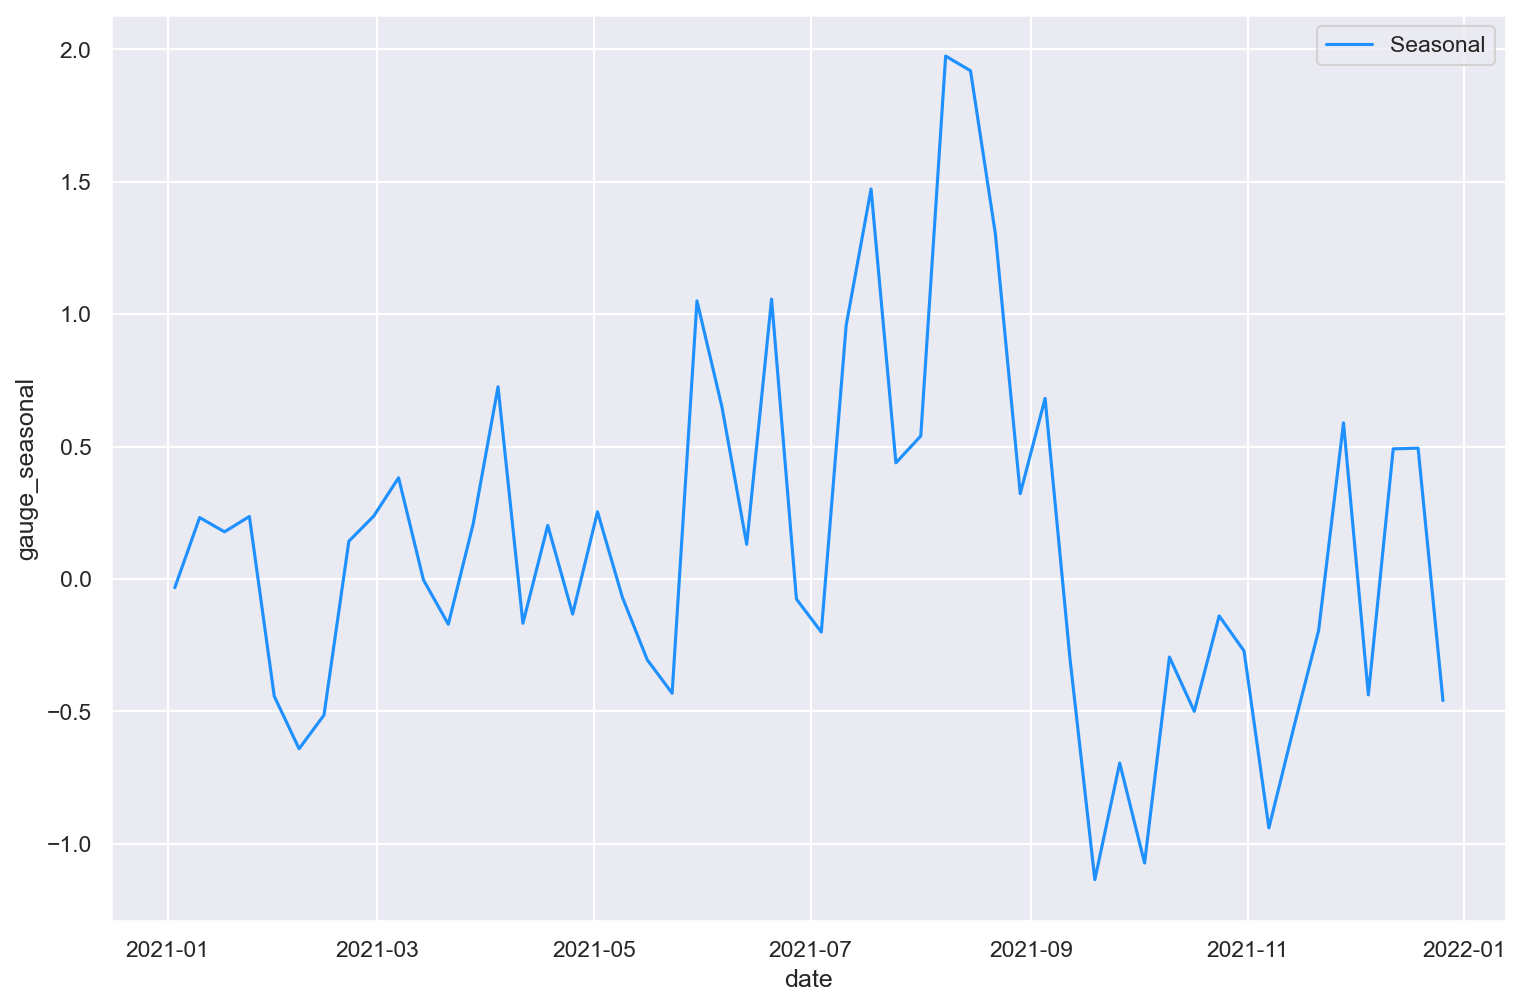

In [17]:
for df in [gauge, gauge_3yr, gauge_2020, gauge_2021]:
	plt.figure(figsize=(12,8), dpi=150)
	sns.lineplot(x=df['date'], y=df['gauge_seasonal'], color='dodgerblue', label='Seasonal')
	plt.show()

## Autocorrelation Analysis

ACF and PACF plots: After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. Of course, with software like Statgraphics, you could just try some different combinations of terms and see what works best. But there is a more systematic way to do this. By looking at the **autocorrelation function (ACF)** and **partial autocorrelation (PACF)** plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed.

* **Autocorrelation Function (ACF)**: P = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series. P corresponds with MA parameter
* **Partial Autocorrelation Function (PACF)**: D = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary. D corresponds with AR parameter.

Autocorrelation plots help in detecting seasonality.

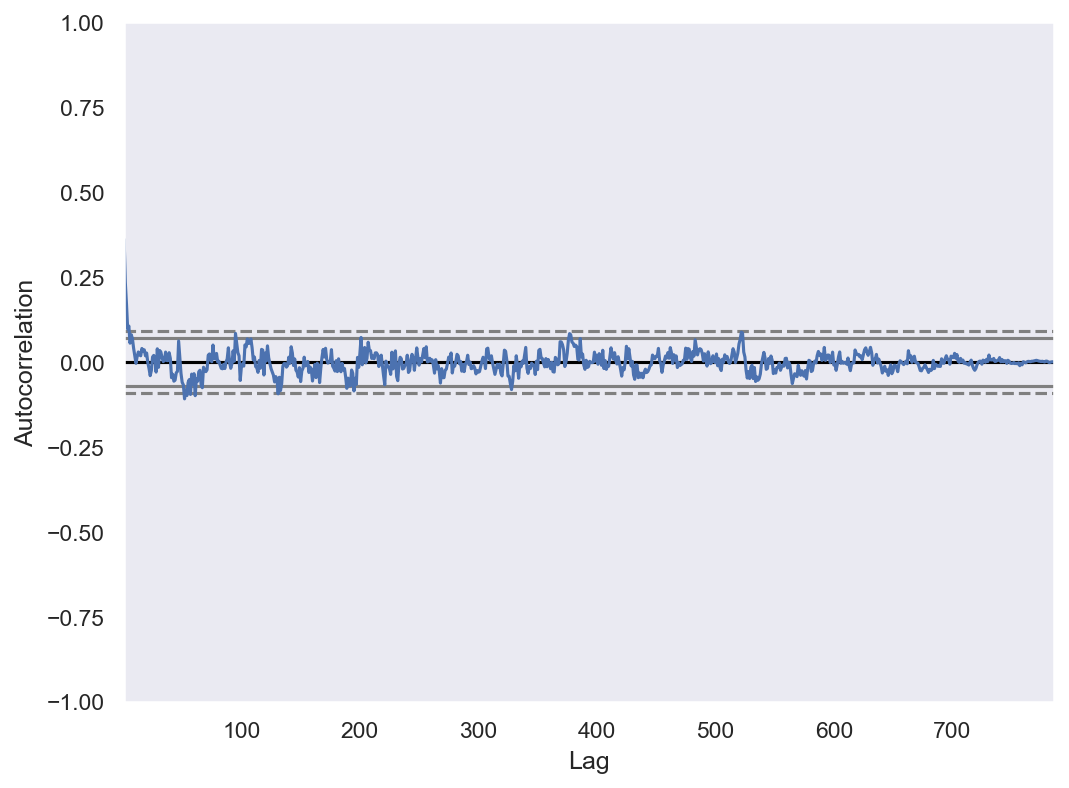

In [18]:
plt.gcf().set_size_inches(8, 6)
autocorrelation_plot(gauge['gauge'])
plt.show()

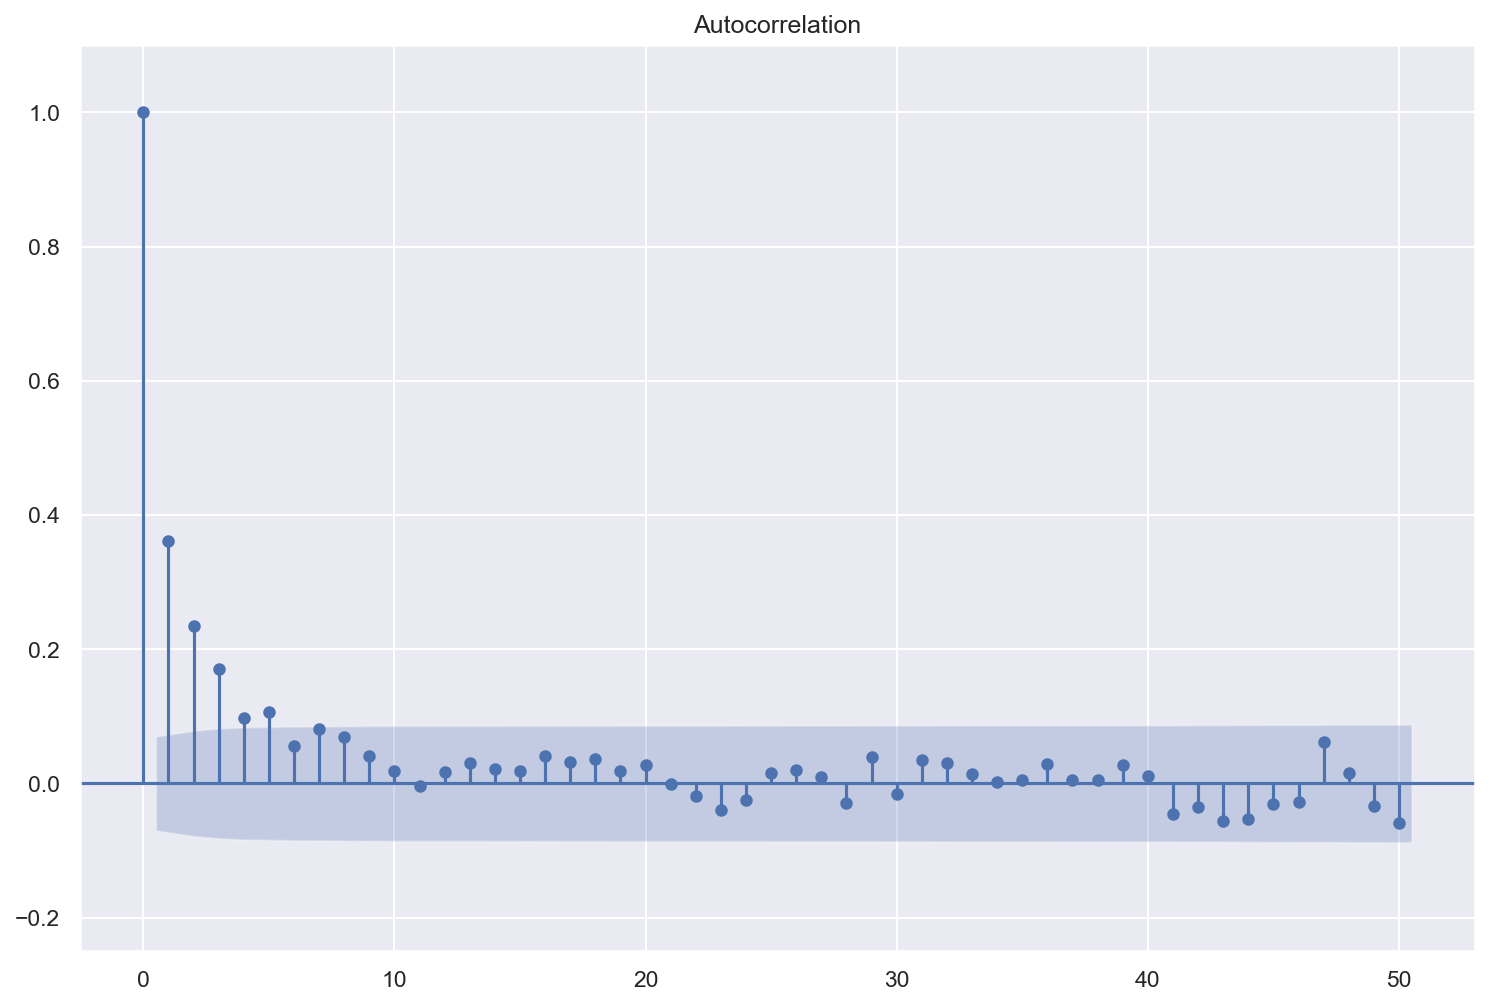

In [19]:
plot_acf(gauge['gauge'], lags=50)
plt.gca().set_ylim([-.25, 1.1])
plt.gcf().set_size_inches(12, 8)

<Figure size 1200x900 with 0 Axes>

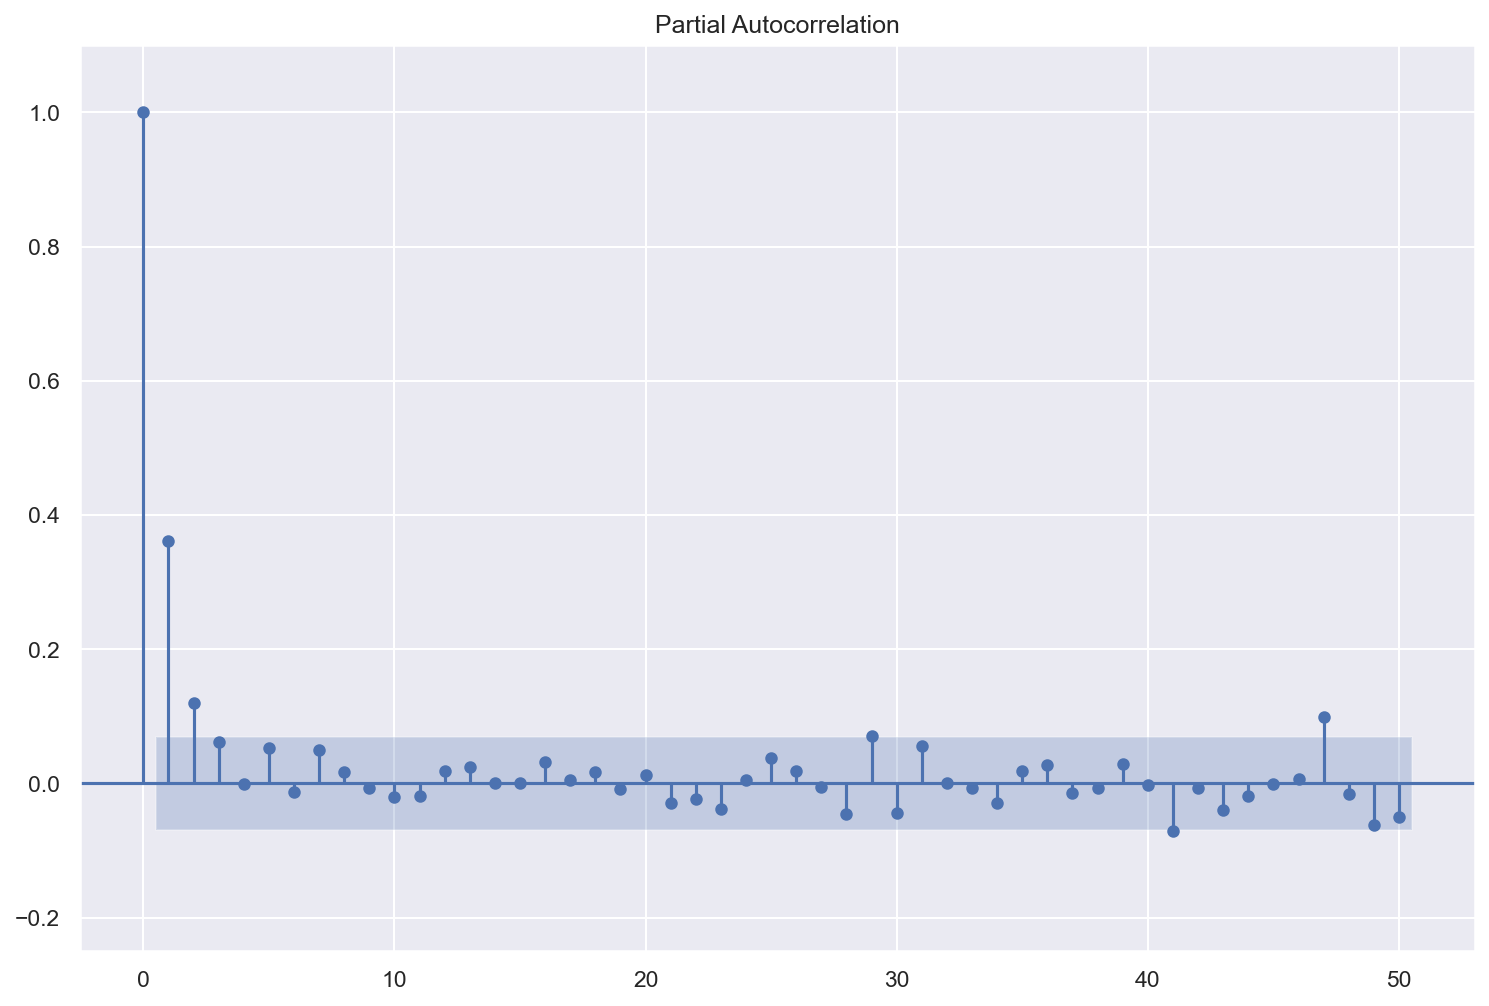

<Figure size 1200x900 with 0 Axes>

In [20]:
plot_pacf(gauge['gauge'], lags=50)
plt.gca().set_ylim([-.25, 1.1])
plt.gcf().set_size_inches(12, 8)
plt.figure(figsize=(8, 6), dpi=150)

## Interpreting ACF and PACF
<img src="https://miro.medium.com/max/1400/1*MJIw0Lh2_PYMKJVTUVWAEw.png"
     alt="Interpreting ACF and PACF Guide" />
Because the ACF plot is geometric and the PACF plot shows 2 highly significant lags, these graphs point to an AR(2) model in ARIMA terms.

## Modeling

Time series can be either univariate or multivariate:

* **Univariate** time series only has a single time-dependent variable.
* **Multivariate** time series have a multiple time-dependent variable.

But first we'll explore cross-validation in Time Series Analysis. 

In [21]:
N_SPLITS = 3

X = gauge['date']
y = gauge['gauge']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

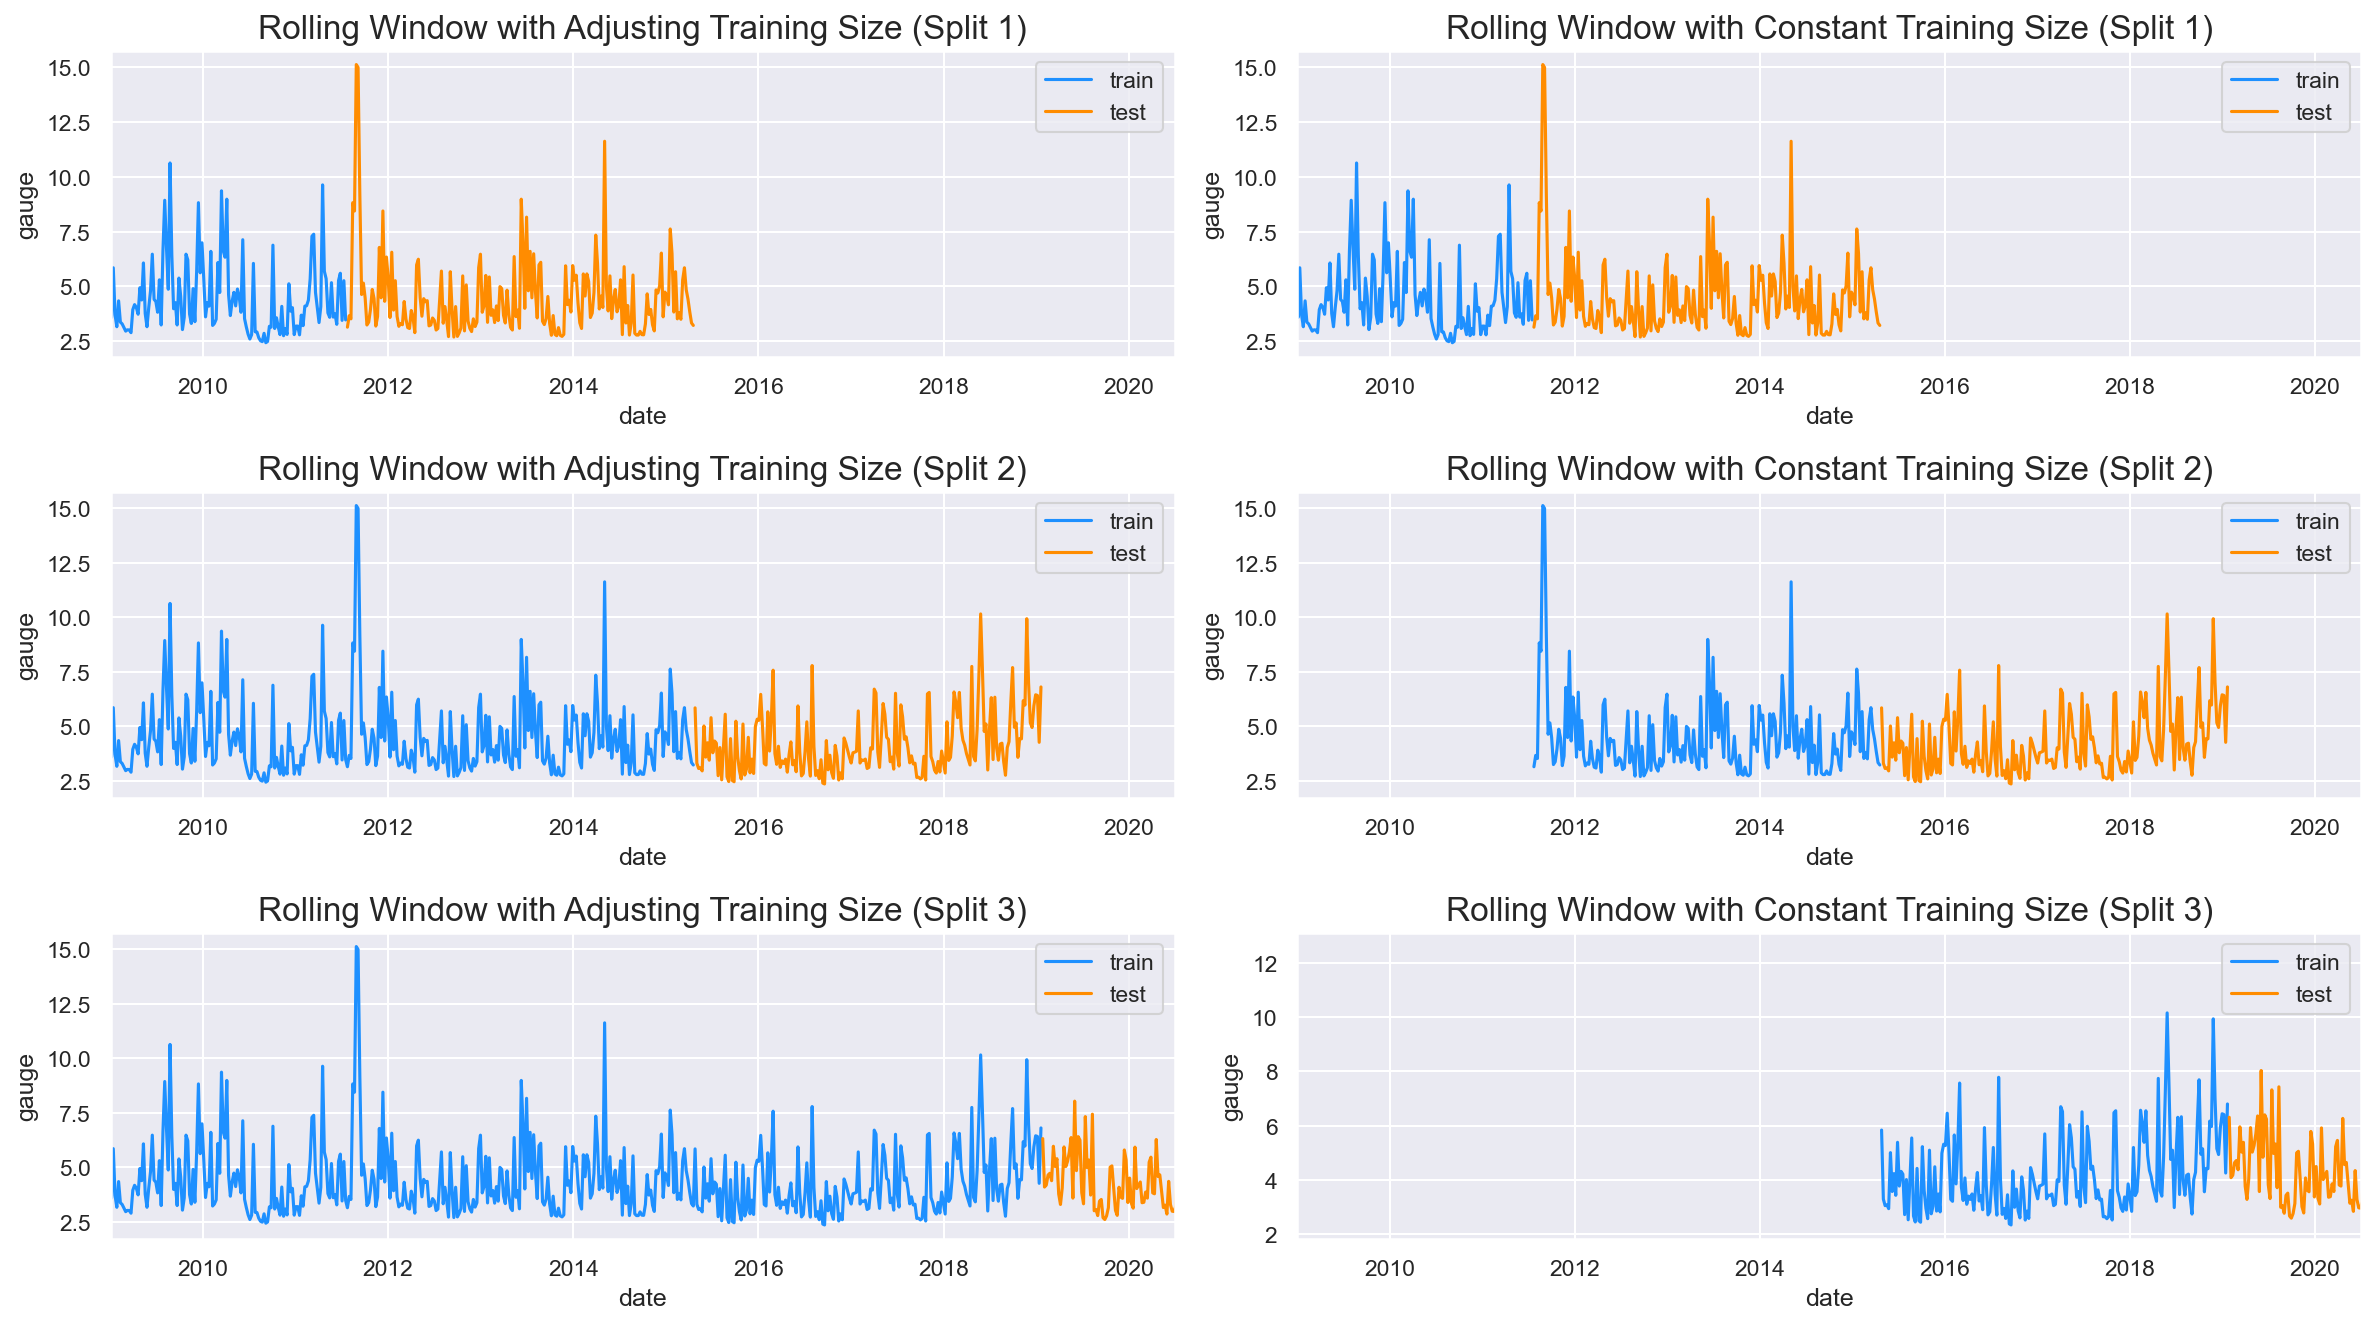

In [22]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, test_index) in enumerate(folds.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_test):(len(X_train) - len(X_test) + len(X_test))], 
        y=y_train[len(X_train) - len(X_test):(len(X_train) - len(X_test) + len(X_test))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_test, y= y_test, ax=ax[i, j], color='darkorange', label='test')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

The idea with this plot is to understand which train and test set are we using to fit the model in each iteration. 

## Models for Univariate Time Series

**Univariate time series**: Only one variable is varying over time. For example, data collected from a sensor measuring the temperature of a room every second. Therefore, each second, you will only have a one-dimensional value, which is the temperature.

In [23]:
train_size = int(0.85 * len(gauge))
test_size = len(gauge) - train_size

univariate_df = gauge[['date', 'gauge']].copy()

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_test, y_test = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(x_train), len(x_test))

668 118


# SARIMA Modeling
Seasonal Autoregressive Integrated Moving Average Model; SARIMA(p, d, q)(P, D, Q)

For our model, we won't be using differencing (integration).

Instead, our challenge lies in choosing the correct seasonality parameter (by month, by week, etc.).

For now, we'll loop through the different periods used in the previous decomposition loop.

In [24]:
gauge_reformat = gauge[['date', 'gauge']].copy().set_index('date')
gauge_reformat.head()

gauge
date             
2007-10-07   2.43
2007-10-14   4.08
2007-10-21   3.33
2007-10-28   6.56
2007-11-04   3.49

In [25]:
def optimize_SARIMA(parameters_list, s, exog):
	"""
		Return dataframe with parameters, corresponding AIC and SSE
		
		parameters_list - list with (p, q, P, Q) tuples
		d - integration order
		D - seasonal integration order
		s - length of season
		exog - the exogenous variable
	"""
	
	results = []
	cached_aic = 10e10
	
	for param in parameters_list:
		try: 
			model = SARIMAX(exog, order=(param[0], 0, param[1]), seasonal_order=(param[2], 0, param[3], s)).fit(disp=-1)
		except:
			continue
		
		aic = model.aic
		if aic < cached_aic:
			cached_aic = aic
			print(f'new aic: {cached_aic}')
		results.append([param, aic])
		
	result_df = pd.DataFrame(results)
	result_df.columns = ['(p,q)x(P,Q)', 'AIC']
	#Sort in ascending order, lower AIC is better
	result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
	
	return result_df

In [26]:
p = range(0, 4, 1)
d = 0
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = periods.copy()
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


### First test with 12 months for the seasonality

In [27]:
results = optimize_SARIMA(parameters_list, 52, y_train)
results.head()

new aic: 3941.838101770044
new aic: 3565.51464971537
new aic: 3353.1341337381255
new aic: 3227.293776790878
new aic: 3069.84303132368
new aic: 2734.3824612567287
new aic: 2725.3436722911997
new aic: 2724.812176601301


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new aic: 2637.550502942533
new aic: 2631.307506970341


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new aic: 2607.9481030284533
new aic: 2604.632236844571
new aic: 2604.5819861441396


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new aic: 2576.757398374665
new aic: 2572.531779151326


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new aic: 2440.698148414458
new aic: 2438.8931401918853
new aic: 2438.6170473773636


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new aic: 2412.072506099017
new aic: 2409.519587947829
new aic: 2409.2719503949775


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

new aic: 2405.818481363829
new aic: 2403.511216197602
new aic: 2403.276003056436


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

new aic: 2401.1686893899687
new aic: 2398.0877768061127
new aic: 2397.8681469031662


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

new aic: 2392.5638358921597


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new aic: 2390.658683236155


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

(p,q)x(P,Q)          AIC
0  (2, 2, 0, 1)  2390.658683
1  (2, 2, 1, 0)  2390.956789
2  (2, 2, 0, 2)  2391.901102
3  (2, 2, 2, 0)  2392.041381
4  (2, 2, 0, 0)  2392.563836

### Analyzing Results:
- Best model is the top row of the results dataframe with (p,q)x(P,Q) of (3, 3, 2, 2) and an AIC ~22
- We found that the model below works quite well

In [36]:
best_model = SARIMAX(y_train, order=(2, 0, 2), seasonal_order=(0, 0, 1, 52),
					 enforce_invertibility=False, enforce_stationarity=False).fit()
print(best_model.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68088D+00    |proj g|=  9.70490D-02

At iterate    5    f=  1.67141D+00    |proj g|=  6.07807D-02

At iterate   10    f=  1.66855D+00    |proj g|=  3.09514D-02

At iterate   15    f=  1.66817D+00    |proj g|=  8.01762D-02

At iterate   20    f=  1.66093D+00    |proj g|=  1.86594D+00

At iterate   25    f=  1.64055D+00    |proj g|=  2.71261D+00

At iterate   30    f=  1.63870D+00    |proj g|=  1.76195D+00

At iterate   35    f=  1.63818D+00    |proj g|=  7.40522D-01

At iterate   40    f=  1.63786D+00    |proj g|=  2.06707D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


                                      SARIMAX Results                                       
Dep. Variable:                                gauge   No. Observations:                  668
Model:             SARIMAX(2, 0, 2)x(0, 0, [1], 52)   Log Likelihood               -1094.088
Date:                              Wed, 09 Nov 2022   AIC                           2200.177
Time:                                      23:48:26   BIC                           2226.687
Sample:                                           0   HQIC                          2210.487
                                              - 668                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6058      0.067     24.071      0.000       1.475       1.737
ar.L2         -0.60

Figure(2250x1800)


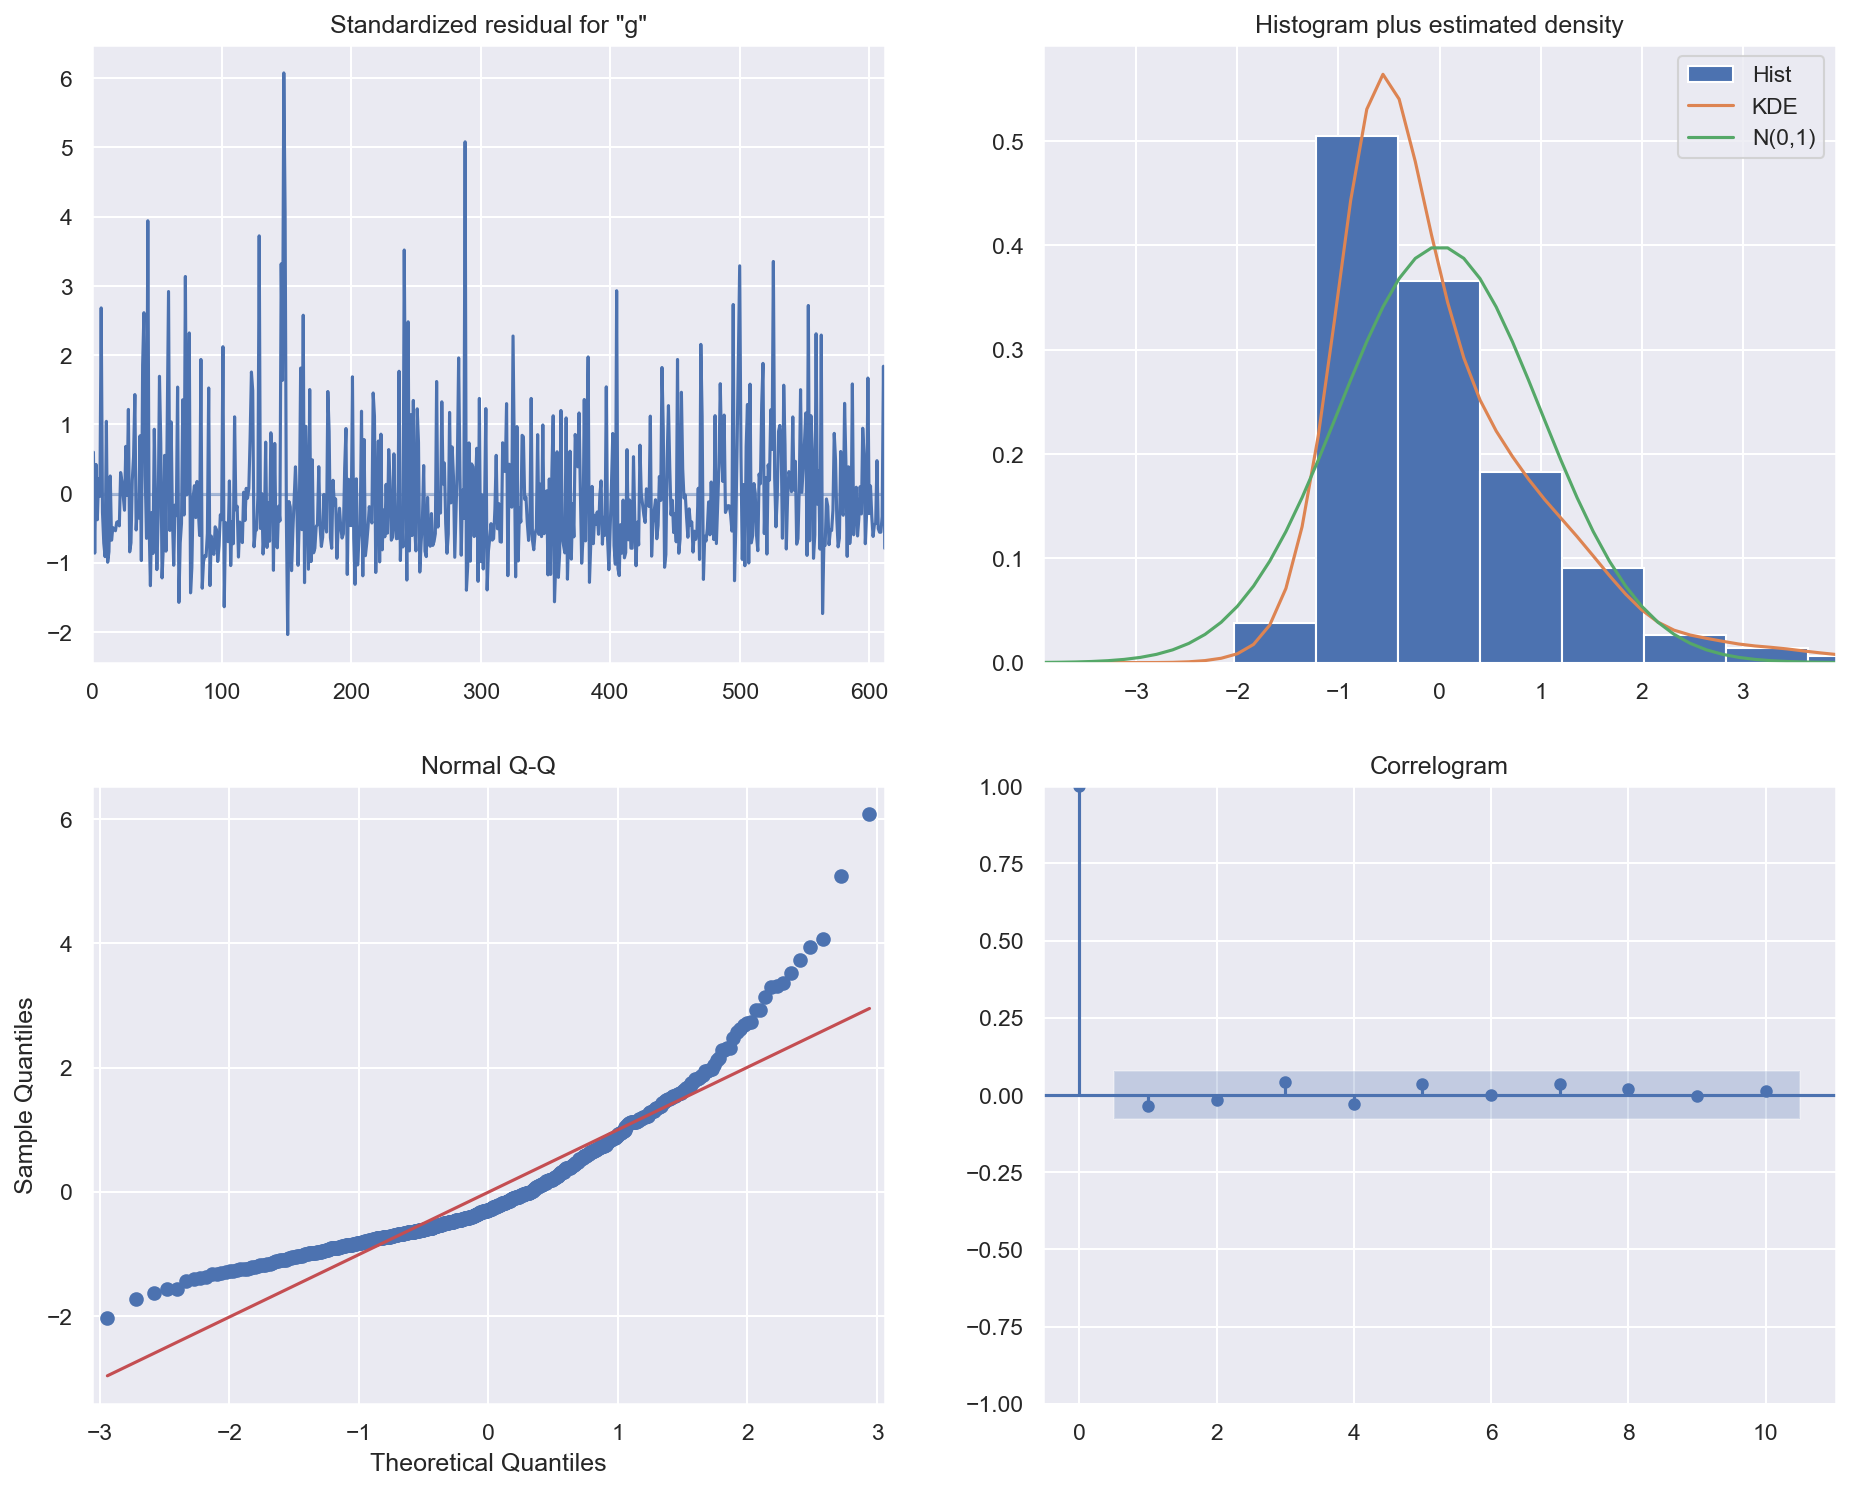

In [44]:
# Need print statement because otherwise it prints diagnostics twice
diagnostics = best_model.plot_diagnostics(figsize=(15,12))
print(diagnostics)
plt.savefig('weekly_diag.png')

### Intepreting Residual Plots
- Normal Q-Q plot: close to a straight line, which suggests no systematic departure from normality
- Correlogram: no autocorrelation in the residuals (meaning no statistically significant lags after the first lag) so they are effectively white noise
- Overall, these are the results we want to see

In [38]:
gauge['sarima'] = best_model.fittedvalues

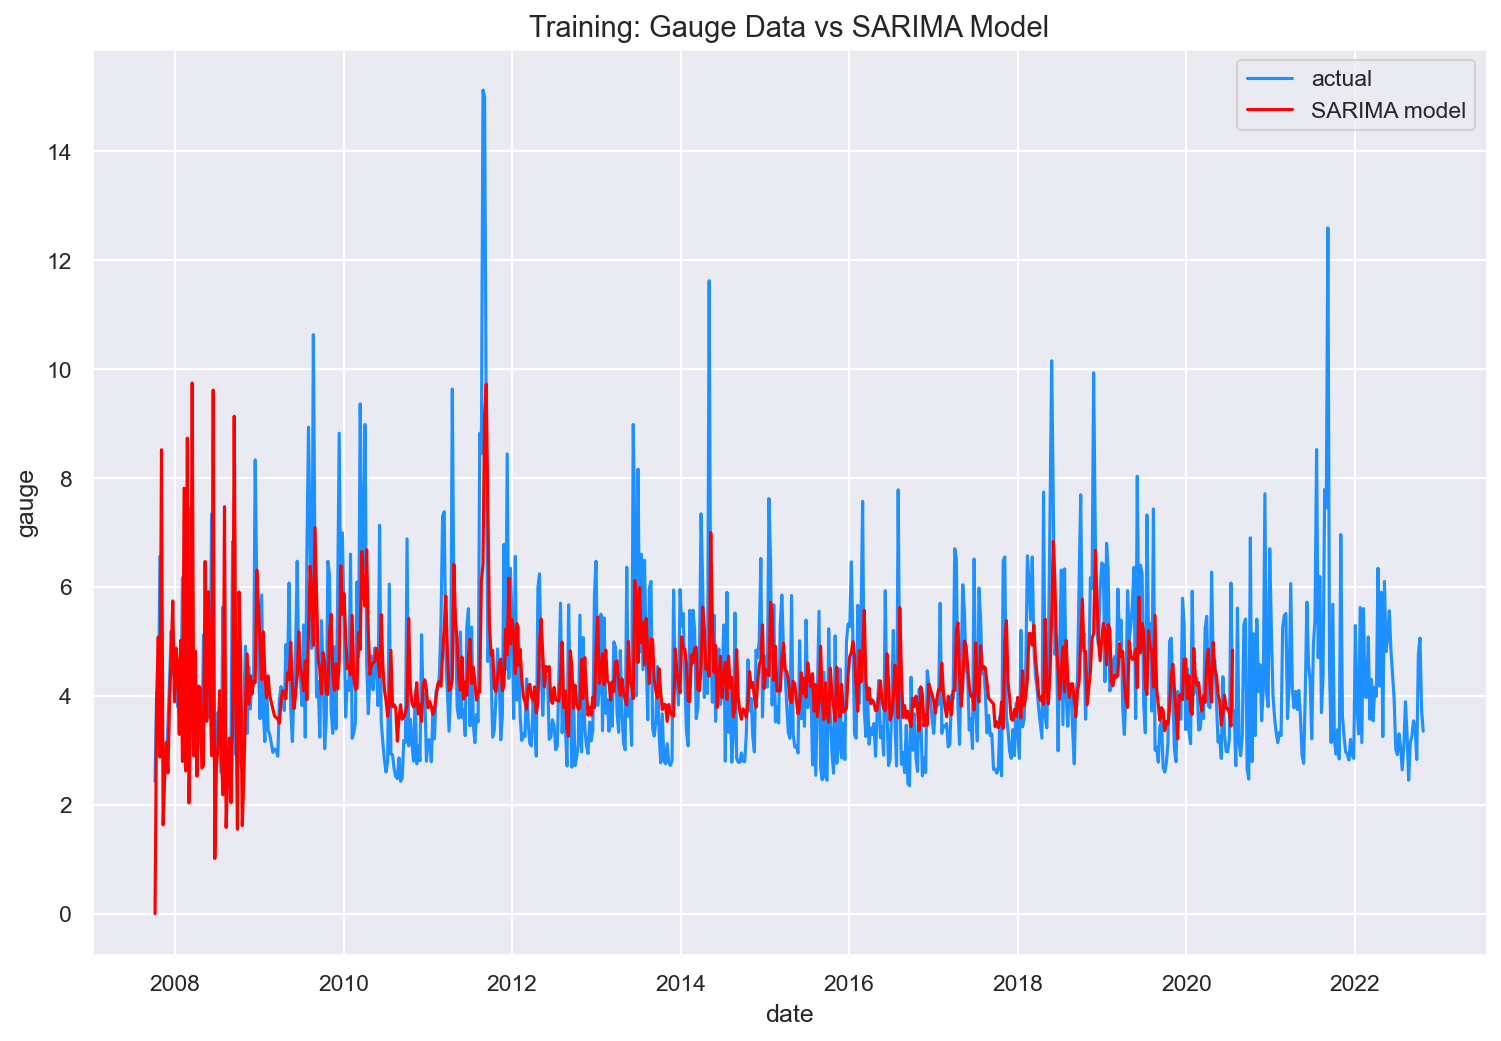

In [39]:
plt.figure(figsize=(12,8), dpi=150)

sns.lineplot(x=gauge['date'], y=gauge['gauge'], color='dodgerblue', label='actual')
sns.lineplot(x=gauge['date'], y=gauge['sarima'], color='red', label='SARIMA model')
		 
plt.title('Training: Gauge Data vs SARIMA Model', fontsize=14)
plt.show()

### SARIMA Forecasting
First, forecast on test data. Then, forecast into the future

In [40]:
forecast_y_test = best_model.forecast(steps=test_size)
forecast_y_test = pd.DataFrame(forecast_y_test.values)
forecast_y_test.rename(columns={0: 'Forecast'}, inplace=True)
forecast_y_test['Date'] = x_test.values
forecast_y_test['Actual'] = y_test.values
forecast_y_test = forecast_y_test[['Date', 'Actual', 'Forecast']]
forecast_y_test.head()

Date  Actual  Forecast
0 2020-07-26    3.73  4.122100
1 2020-08-02    2.72  4.259032
2 2020-08-09    5.61  3.972212
3 2020-08-16    3.14  4.318644
4 2020-08-23    2.90  4.320566

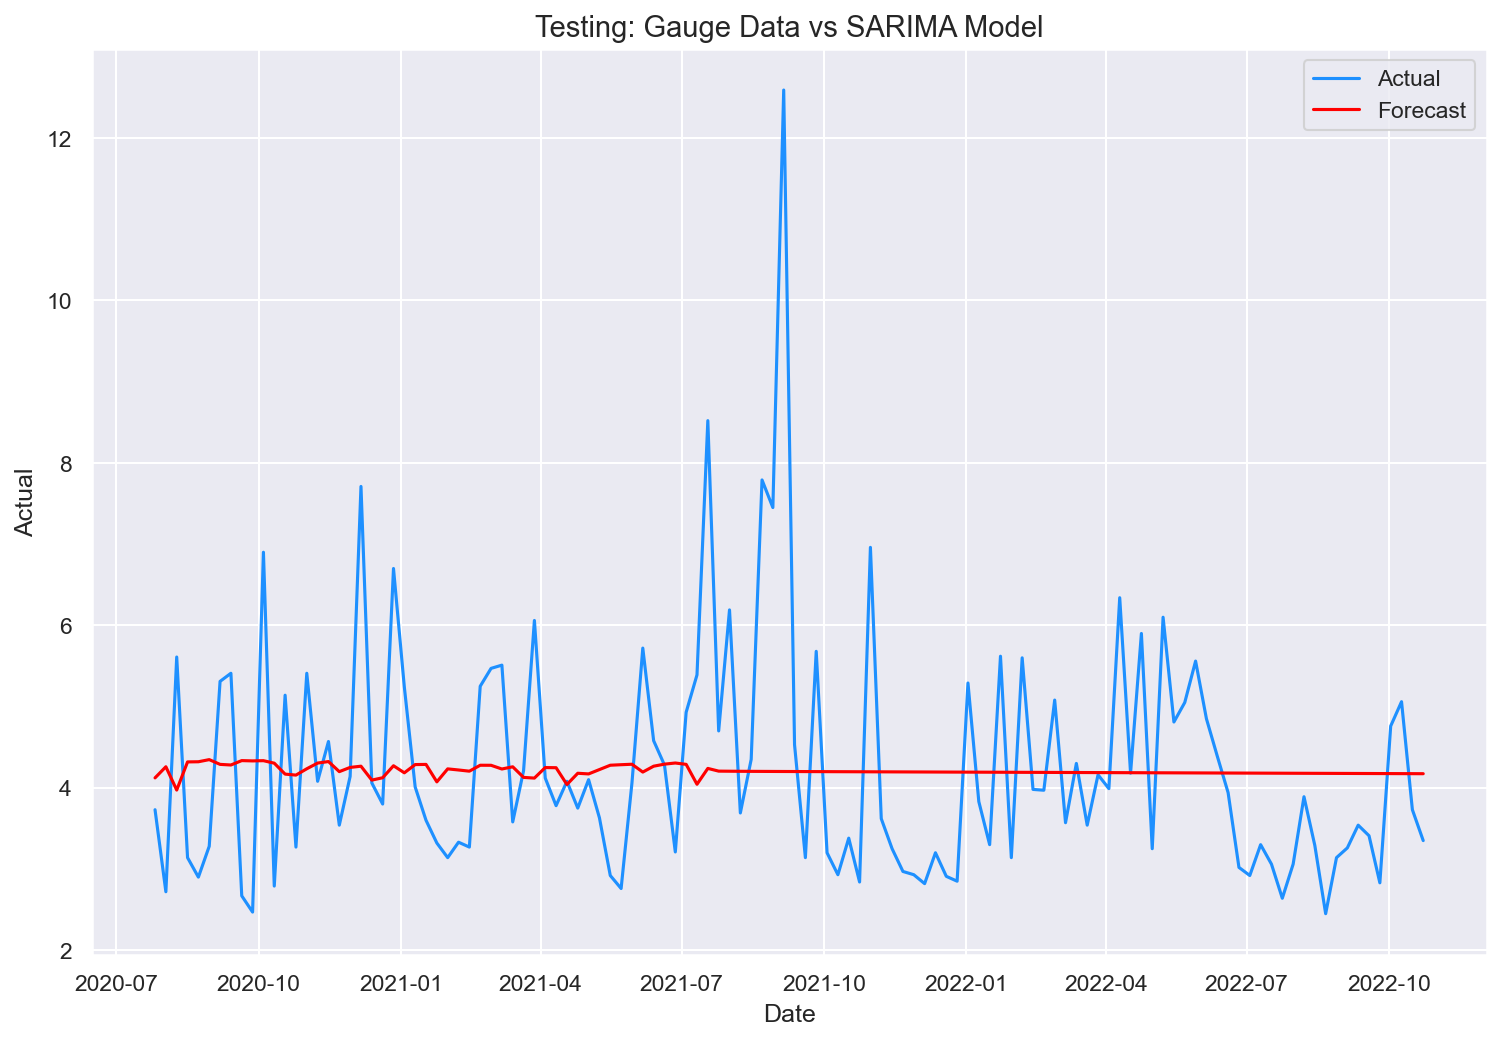

In [41]:
plt.figure(figsize=(12,8), dpi=150)

sns.lineplot(x=forecast_y_test['Date'], y=forecast_y_test['Actual'], color='dodgerblue', label='Actual')
sns.lineplot(x=forecast_y_test['Date'], y=forecast_y_test['Forecast'], color='red', label='Forecast')
		 
plt.title('Testing: Gauge Data vs SARIMA Model', fontsize=14)
plt.show()

### Forecasting Next Year – Problems
- Need to generaate time series to represent months here
- NO FLOODS HERE

In [34]:
forecast_2023 = best_model.forecast(steps=40)
forecast_2023
# sns.lineplot(x=forecast_y_test['Date'], y=forecast_y_test['Actual'], color='dodgerblue', label='Actual')

668    3.984889
669    4.283830
670    3.830321
671    4.353002
672    4.358836
673    4.443427
674    4.304462
675    4.348989
676    4.357975
677    4.348873
678    4.363314
679    4.320612
680    4.167176
681    4.007082
682    4.129963
683    4.314020
684    4.308304
685    4.111023
686    4.191108
687    4.236392
688    3.986269
689    3.988401
690    4.208251
691    4.088354
692    4.188140
693    4.236696
694    3.910291
695    4.143753
696    4.082815
697    4.057929
698    4.156439
699    4.165861
700    4.117330
701    4.172603
702    3.985518
703    3.981969
704    4.184006
705    4.207667
706    3.761732
707    4.058981
Name: predicted_mean, dtype: float64

### Our forecast: max values daily
Need to classify these values as minor, moderate, major floods

In [42]:
# minor_filter = np.where((daily_max['gauge'] >= 8.5) & (daily_max['gauge'] < 9.5))
# moderate_filter = np.where((daily_max['gauge'] >= 9.5) & (daily_max['gauge'] < 11))
# major_filter = np.where(daily_max['gauge'] > 11)

In [ ]:
major_flood = daily_max.loc[major_filter]

Get dates and counts of predicted flood statuses 

Use [forecast](https://medium.datadriveninvestor.com/time-series-prediction-using-sarimax-a6604f258c56) method on the result dataframe so that we can forecast the next year's values